# Loading Data

## Imports

In [1]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, ReLU, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Activation
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras import metrics
# import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow import keras
import keras_tuner as kt

from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, concatenate
import tensorflow as tf

from os.path import join
from os import listdir
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Creating data loaders

In [2]:
IMAGE_SIZE = (64,64)

In [3]:
# import pandas as pd
# import numpy as np

# # Assuming you have already read the CSV into df
# df = pd.read_csv('.\\final_data.csv', names=["path", "value"])

# # Remove entries with "Artificial" in the 'path'
# df = df[~df['path'].str.contains("Artificial")]

# df.reset_index(inplace=True, drop=True)

# # Select 20 random entries for the TEST set
# # test_indices = np.random.choice(df.index, size=20, replace=False)
# test_indices = []
# for i in range(5):
#     test_indices.extend(np.random.choice([j+(i*20) for j in range(20)], size=4, replace=False))
# test_indices = np.array(test_indices)
# test_df = df.loc[test_indices]

# # Create TRAIN set by excluding TEST entries
# train_df = df.drop(test_indices)

# # Save TEST set to a CSV file
# test_df.to_csv('test_data_v4.csv', index=False)

# # Optionally, save TRAIN set to a CSV file
# train_df.to_csv('train_data_v4.csv', index=False)


In [4]:
train = pd.read_csv('.\\train_data_v4 copy.csv',  names=["path","value"])
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range = 0.3,
        height_shift_range = 0.3, 
        zoom_range = [0.7,1.3],
        horizontal_flip = True,
        vertical_flip = True,
    ).flow_from_dataframe(
    train, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

test = pd.read_csv('.\\test_data_v4.csv',  names=["path","value"])
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    ).flow_from_dataframe(
    test, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

Found 80 validated image filenames.
Found 20 validated image filenames.


c:\Users\nealb\AppData\Local\miniconda3\envs\pd\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\nealb\AppData\Local\miniconda3\envs\pd\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


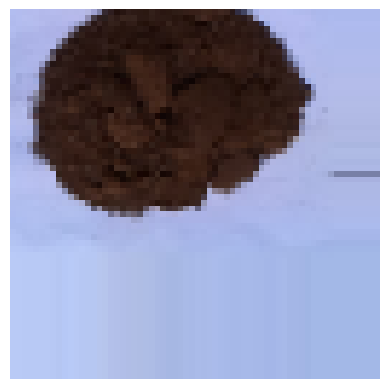

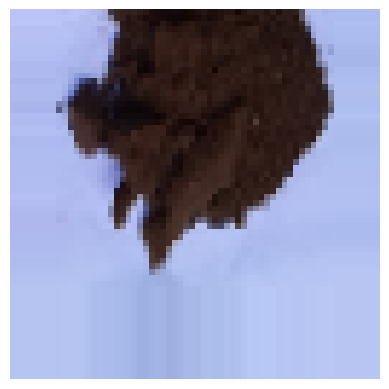

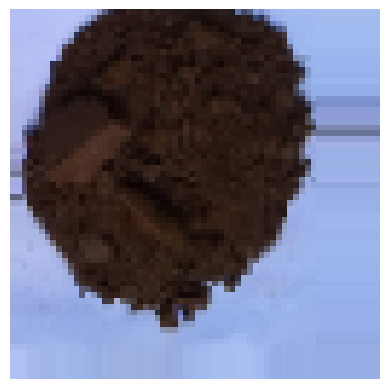

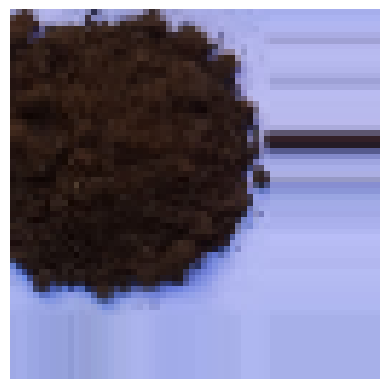

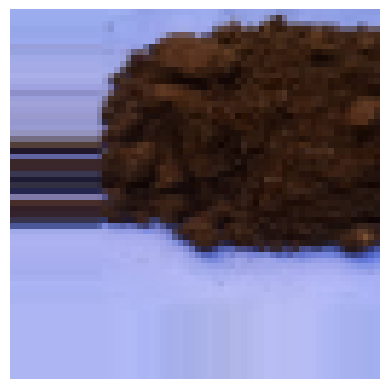

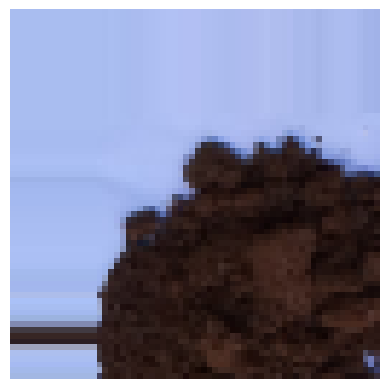

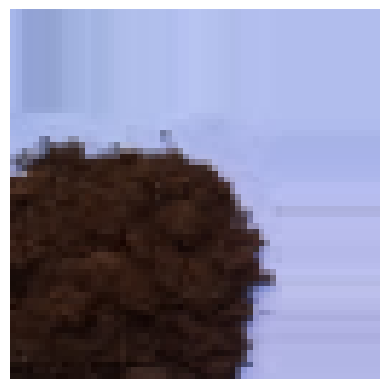

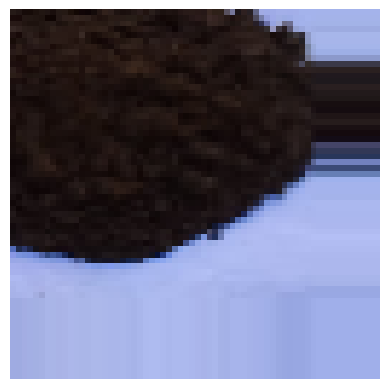

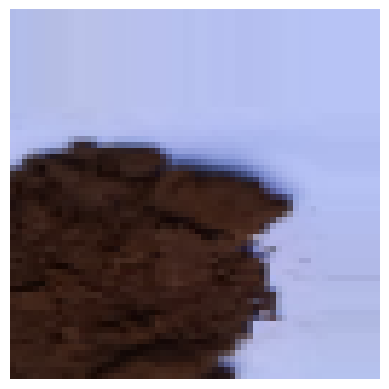

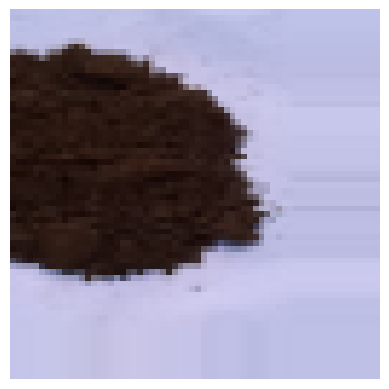

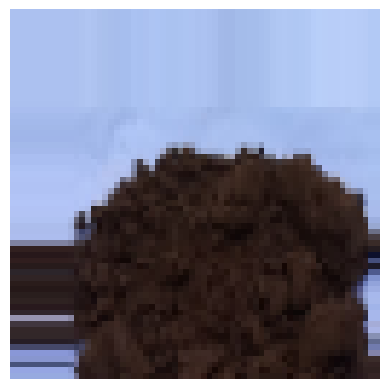

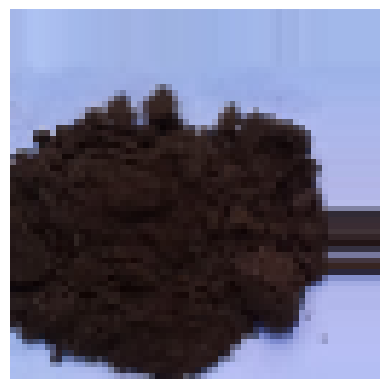

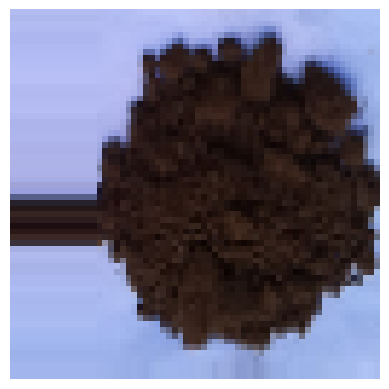

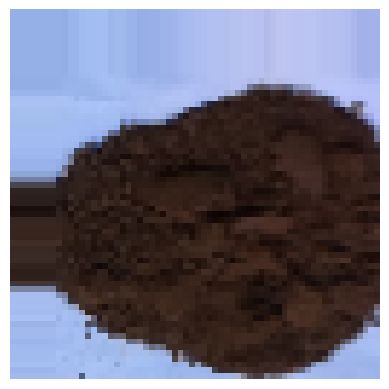

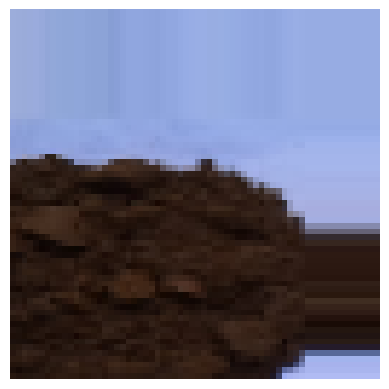

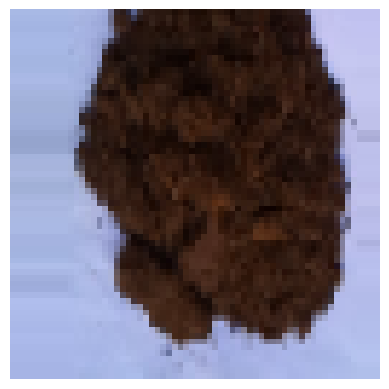

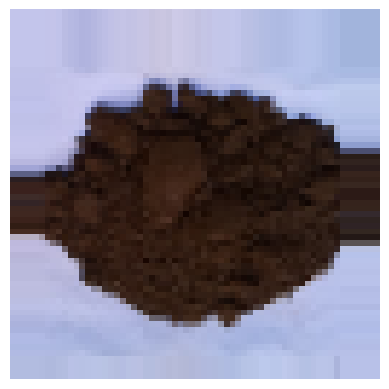

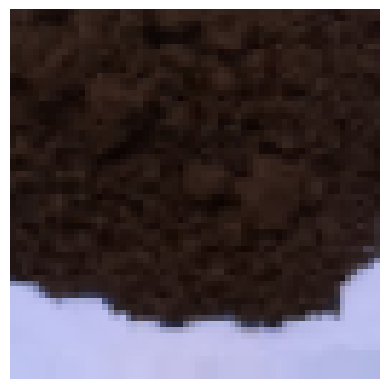

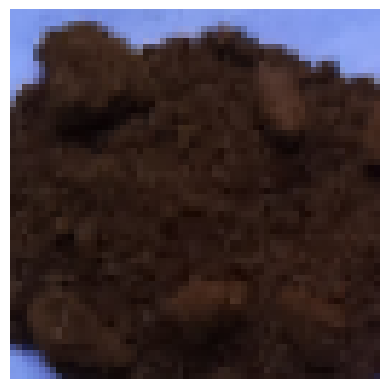

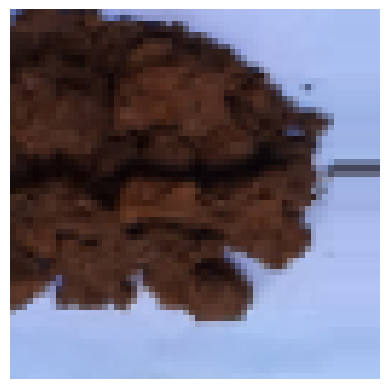

In [5]:
samples = next(train_generator)[0]
for i in range(20):
    plt.imshow(np.array(samples[i]).astype(np.uint8))
    plt.axis("off")
    plt.show()

In [6]:
train = pd.read_csv('.\\train_data_v4 copy.csv',  names=["path","value"])
train_generator_no_aug = tf.keras.preprocessing.image.ImageDataGenerator(
        # width_shift_range = 0.3,
        # height_shift_range = 0.3, 
        # zoom_range = [0.7,1.3],
        # horizontal_flip = True,
        # vertical_flip = True,
        # # brightness_range = (0.5, 1.5),
        # shear_range = 0.3,
        # rotation_range = 45,
    ).flow_from_dataframe(
    train, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=IMAGE_SIZE,
    )

Found 80 validated image filenames.


c:\Users\nealb\AppData\Local\miniconda3\envs\pd\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [7]:
# df = pd.read_csv('.\\final_data.csv',  names=["path","value"])
df = pd.read_csv('.\\train_data_v4 copy.csv',  names=["path","value"])
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    )

data_generator = generator.flow_from_dataframe(
    df, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=99,
    target_size=IMAGE_SIZE,
    )

Found 80 validated image filenames.


c:\Users\nealb\AppData\Local\miniconda3\envs\pd\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [8]:
epochs = 128
REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=1e-8)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True)

In [9]:
Xs_TRAIN = []
Ys_TRAIN = []
Xs_TEST = []
Ys_TEST = []
Xs = []
Ys = []
iterations = 3
for i in range(iterations):
    x,y = next(train_generator)
    Xs_TRAIN.extend([np.array(value).astype(int) for value in x])
    Ys_TRAIN.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])

x,y = next(train_generator_no_aug)
Xs_TRAIN.extend([np.array(value).astype(int) for value in x])
Ys_TRAIN.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])


x,y = next(val_generator)
Xs_TEST.extend([np.array(value).astype(int) for value in x])
Ys_TEST.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])
    
    
for i in range(iterations):
    x,y = next(data_generator)
    Xs.extend([np.array(value).astype(int) for value in x])
    Ys.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])
    

In [10]:
MAXPH = np.max(np.array(Ys)[:,1])
MINPH = np.min(np.array(Ys)[:,1])

MAXMOISTURE = np.max(np.array(Ys)[:,0])
MINMOISTURE = np.min(np.array(Ys)[:,0])

In [11]:
print(MAXPH)
print(MINPH)
print(MAXMOISTURE)
print(MINMOISTURE)

5.69
3.53
0.4
0.1


In [12]:

def get_mask(image):
    image = image.astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binr = cv2.threshold(gray, 16, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    binr = np.invert(binr)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(binr, kernel, iterations=3)
    mask = (mask // 255).astype(np.uint8)
    return mask

def process_image(image):
    rgb_image = image.astype(np.uint8)
    mask = get_mask(rgb_image)
    gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    rgb_planes = cv2.split(rgb_image)
    result_planes = []
    for plane in rgb_planes:
        processed_image = cv2.medianBlur(plane, 7)
        processed_image = cv2.bitwise_and(processed_image, processed_image, mask=mask)
        result_planes.append(processed_image)
    result = cv2.merge(result_planes)
    return result

def process_label(image, label):
    mask = get_mask(np.array(image))
    mask = mask.astype(np.uint8)
    moisture = np.zeros_like(mask, dtype=np.float32)
    ph = np.zeros_like(mask, dtype=np.float32)
    moisture_value = label[0] *10
    ph_value = label[1]
    moisture[mask == 1] = moisture_value
    ph[mask == 1] = ph_value
    return moisture, ph

In [13]:
def mask_labels(mask, label):
    channel_0 = cv2.bitwise_and(label[0][0], label[0][0], mask=mask)
    channel_1 = cv2.bitwise_and(label[1][0], label[1][0], mask=mask)
    return [channel_0, channel_1]

def unprocess_label(label):
    label = np.array(label, dtype=float)
    label_0_flat = label[0].flatten()
    label_1_flat = label[1].flatten()
    filtered_label_0 = label_0_flat[label_0_flat != 0]
    filtered_label_1 = label_1_flat[label_1_flat != 0]
    moisture = filtered_label_0 / 10
    ph = filtered_label_1
    return [np.mean(moisture), np.mean(ph)]

def unprocess_label_wmask(image, label):
    
    def make_mask(image):
        image = np.array(image, dtype=np.uint8)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        mask = (gray > 0).astype(np.uint8)
        return mask

    unnormalized_image = np.array(image * 255).astype(np.uint8)
    mask = make_mask(unnormalized_image)

    # Mask the labels
    masked_labels = mask_labels(mask, label)
    results = unprocess_label(masked_labels)
    return results

In [14]:
X_train = []
X_test = []
y_train = []
y_test = []
for i, x in enumerate(Xs_TRAIN):
    y_train.append(process_label(Xs_TRAIN[i], Ys_TRAIN[i]))
    X_train.append(process_image(Xs_TRAIN[i]))

for i, x in enumerate(Xs_TEST):
    y_test.append(process_label(Xs_TEST[i], Ys_TEST[i]))
    X_test.append(process_image(Xs_TEST[i]))

In [15]:
len(X_train)//4

80

In [16]:
np.array(X_train).shape

(320, 64, 64, 3)

In [17]:
TRAIN_RANGE = np.array(X_train).shape[0] - (np.array(X_train).shape[0]%4)
TEST_RANGE = 20


In [18]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# class MultiOutputDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, dataframe, x_col, y_col, batch_size, target_size, rescale=None, augment_params=None):
#         self.dataframe = dataframe
#         self.x_col = x_col
#         self.y_col = y_col
#         self.batch_size = batch_size
#         self.target_size = target_size
#         self.rescale = rescale
#         self.image_data_generator = ImageDataGenerator(**augment_params) if augment_params else ImageDataGenerator()
#         self.on_epoch_end()

#     def __len__(self):
#         return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_df = self.dataframe.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_x = np.array([self.load_and_process_image(path) for path in batch_df[self.x_col]])
#         batch_y = []
#         for i in range(len(self.y_col)):
#             batch_y.append(self.process_label(batch_df[self.x_col][i], batch_x[i]))
#         batch_y = np.array(batch_y)
#         batch_y = np.array([self.process_label(value) for value in batch_df[self.y_col]])
#         batch_y_moisture = batch_y[:, 0]
#         batch_y_ph = batch_y[:, 1]

#         if self.rescale:
#             batch_x = batch_x * self.rescale

#         return batch_x, {'moisture_output': batch_y_moisture, 'ph_output': batch_y_ph}

#     def on_epoch_end(self):
#         self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

#     def load_and_process_image(self, image_path):
#         image = tf.keras.preprocessing.image.load_img(image_path, target_size=self.target_size)
#         image = tf.keras.preprocessing.image.img_to_array(image)
#         image = process_image(image)
#         return self.image_data_generator.random_transform(image)

#     def process_label(self, label, image):
#         label = np.array(label.replace("'", "")[1:-1].split(', ')).astype(float)
#         label = unprocess_label_wmask(image, label)
#         return label

# # Load the data
# train_df = pd.read_csv('.\\train_data_v2.csv', names=["path", "value"])
# test_df = pd.read_csv('.\\test_data_v2.csv', names=["path", "value"])

# # Augmentation parameters
# augment_params = {
#     'width_shift_range': 0.3,
#     'height_shift_range': 0.3,
#     'zoom_range': [0.7, 1.3],
#     'horizontal_flip': True,
#     'vertical_flip': True,
#     'shear_range': 0.3,
#     'rotation_range': 45
# }

# # Create data generators
# IMAGE_SIZE = (64, 64)
# train_generator = MultiOutputDataGenerator(train_df, x_col="path", y_col="value", batch_size=198, target_size=IMAGE_SIZE, rescale=1./255, augment_params=augment_params)
# val_generator = MultiOutputDataGenerator(test_df, x_col="path", y_col="value", batch_size=198, target_size=IMAGE_SIZE, rescale=1./255)

# # # Example usage in model
# # model = your_model_function()  # Assuming your model is already defined
# # model.compile(optimizer='adam', loss={'moisture_output': huber_moisture, 'ph_output': huber_ph}, metrics={'moisture_output': 'mae', 'ph_output': 'mae'})
# # model.fit(train_generator, validation_data=val_generator, epochs=10)

# train_gen_iter = iter(train_generator)
# val_gen_iter = iter(val_generator)


In [19]:
# next(train_gen_iter)

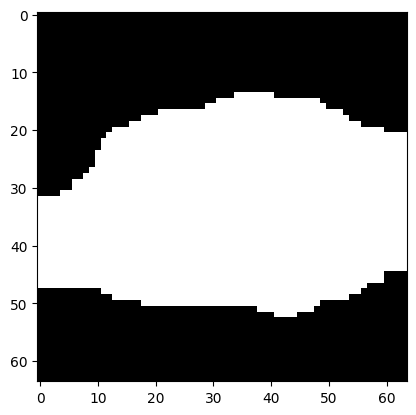

In [20]:
plt.imshow(np.array(y_train)[11][0], cmap="gray")

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class MultiOutputDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, rescale=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.rescale = rescale
        self.indexes = np.arange(len(X))

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = np.array([self.X[i] for i in batch_indexes])
        batch_y = [np.array([self.y[i][0] for i in batch_indexes]),  # Moisture
                   np.array([self.y[i][1] for i in batch_indexes])]  # pH

        if self.rescale:
            batch_X = batch_X * self.rescale

        return batch_X, {'moisture_output': batch_y[0], 'ph_output': batch_y[1]}

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


train_generator = MultiOutputDataGenerator(X_train, y_train, batch_size=4, rescale=1./255)
val_generator = MultiOutputDataGenerator(X_test, y_test, batch_size=4, rescale=1./255)

train_gen_iter = iter(train_generator)
val_gen_iter = iter(val_generator)

In [22]:
SAMPLE_TRAIN = []
SAMPLE_TRAIN_Y = []

## Prepare set of x values and y values
X_values_1,y_values_1 = [],[]
for i in range(np.array(X_train).shape[0]//4):
    values = next(train_gen_iter)
    X_values_1.append(values[0]) 
    y_values_1.append([values[1]['moisture_output'],values[1]['ph_output']])
    SAMPLE_TRAIN.extend(values[0])
    SAMPLE_TRAIN_Y.extend(list(zip(values[1]["moisture_output"], values[1]["ph_output"])))
    
SAMPLE_TRAIN_Y = np.array(SAMPLE_TRAIN_Y)

SAMPLE_TRAIN_Y = SAMPLE_TRAIN_Y[:, :, np.newaxis, :, :, np.newaxis]

## create X_values generator
gen_X_values_1_1 = (x for x in X_values_1)
gen_X_values_2_1 = (x for x in X_values_1)
gen_X_values_3_1 = (x for x in X_values_1)

## Prepare set of x values and y values
X_values_2,y_values_2 = [],[]
SAMPLE = []
SAMPLE_Y = []
for i in range(5):
    values = next(val_gen_iter)
    X_values_2.append(values[0])
    y_values_2.append(list(zip(values[1]["moisture_output"], values[1]["ph_output"])))
    SAMPLE.extend(values[0])
    SAMPLE_Y.extend(list(zip(values[1]["moisture_output"], values[1]["ph_output"])))

## create X_values generator
gen_X_values_1_2 = (x for x in X_values_2)
gen_X_values_2_2 = (x for x in X_values_2)
gen_X_values_3_2 = (x for x in X_values_2)

SAMPLE_Y = np.array(SAMPLE_Y)

SAMPLE_Y = SAMPLE_Y[:, :, np.newaxis, :, :, np.newaxis]

    

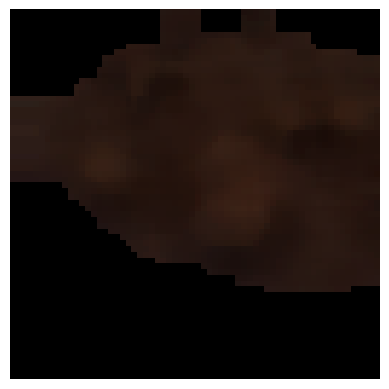

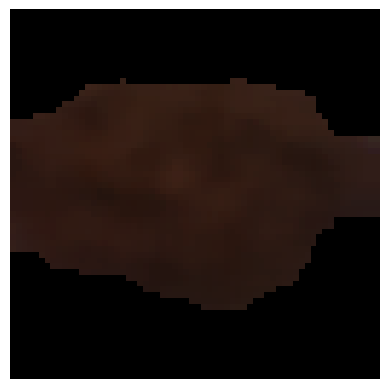

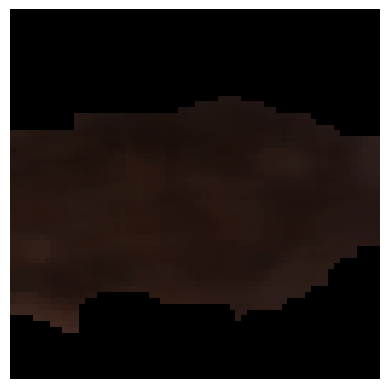

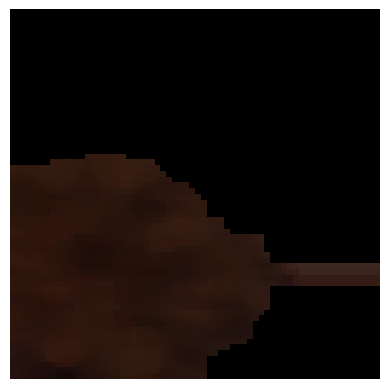

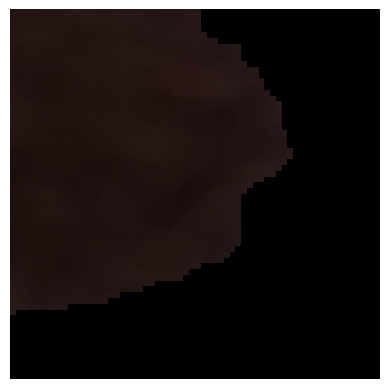

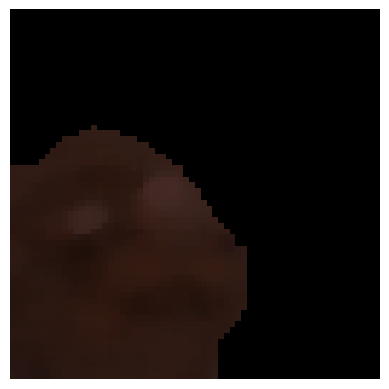

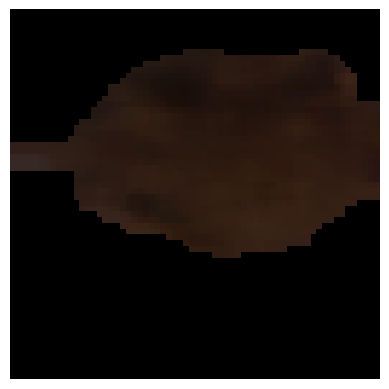

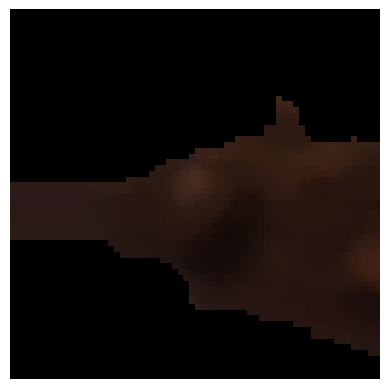

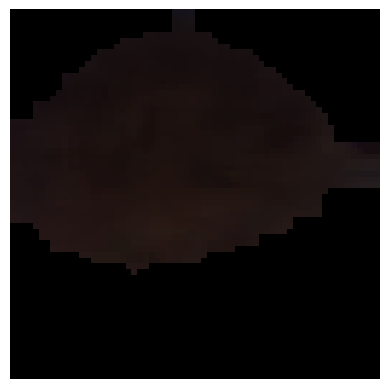

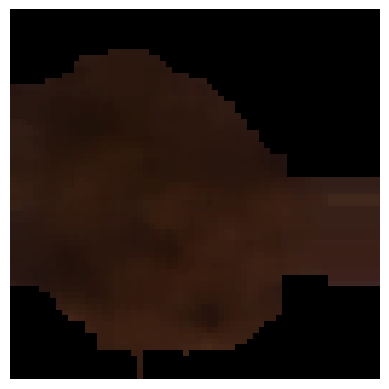

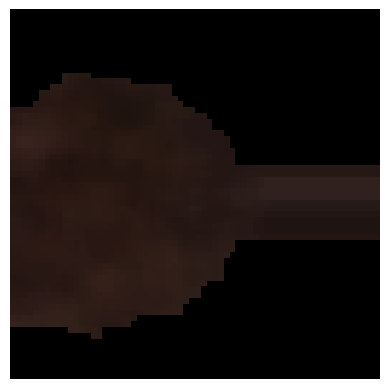

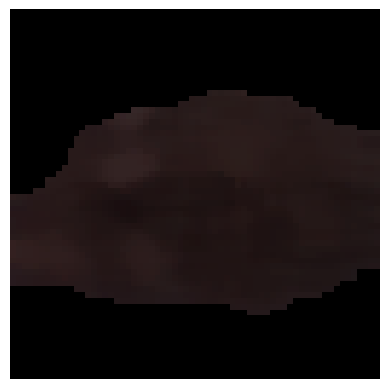

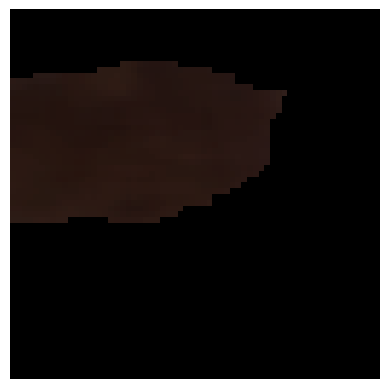

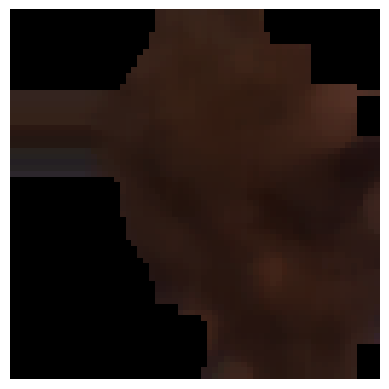

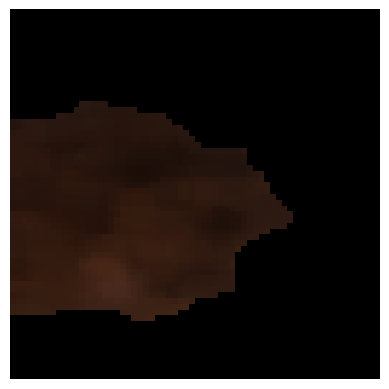

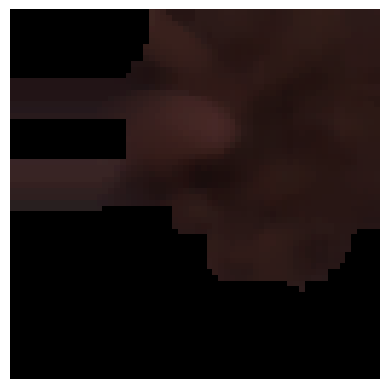

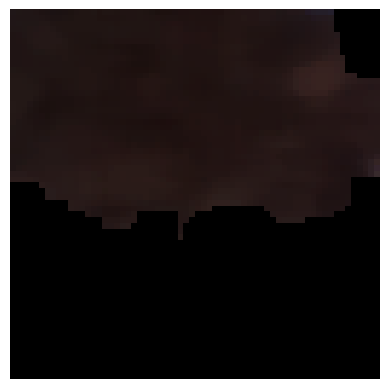

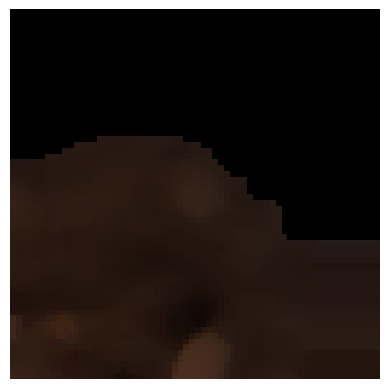

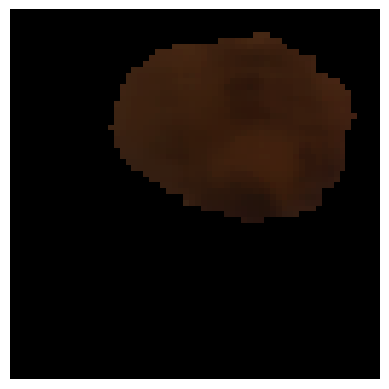

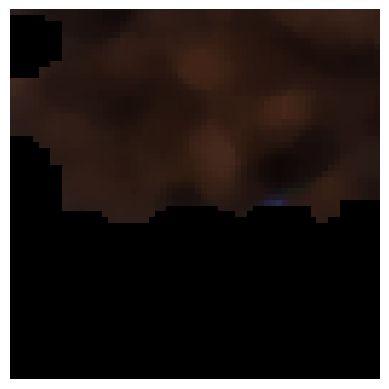

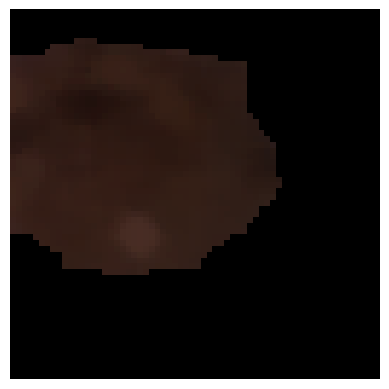

In [23]:
for x,i in enumerate(SAMPLE_TRAIN):
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    if x == 20:
        break

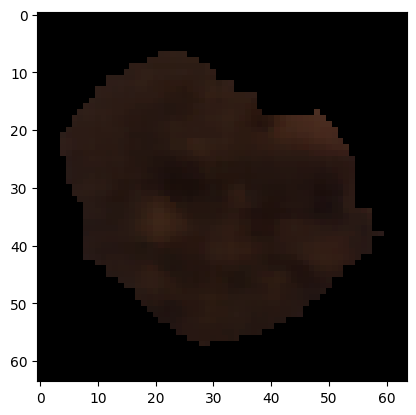

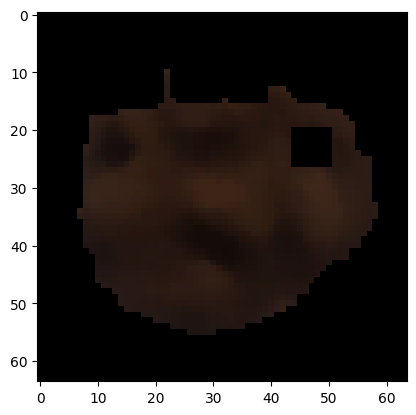

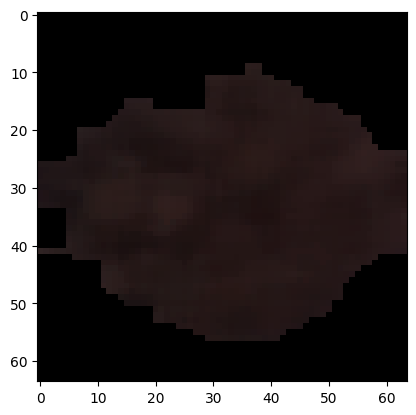

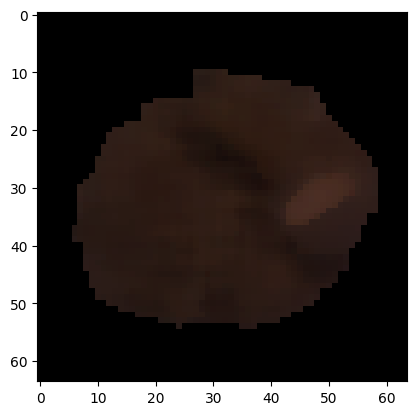

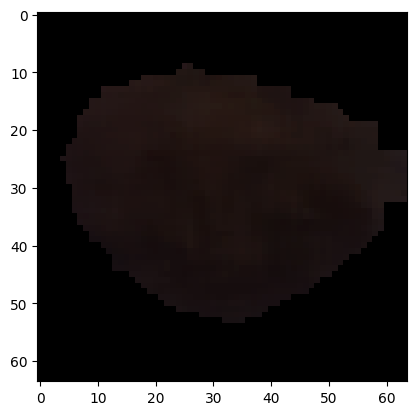

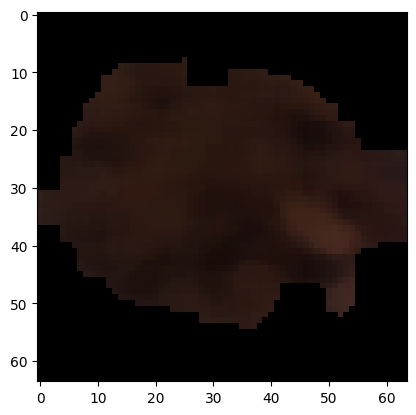

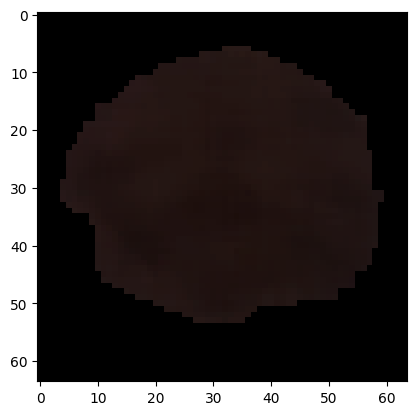

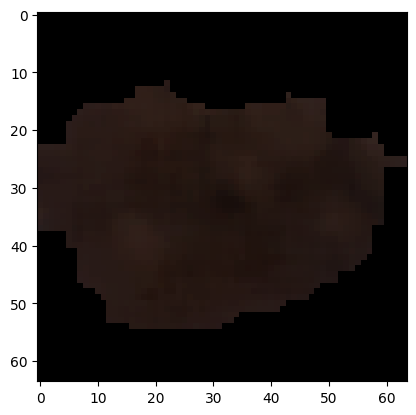

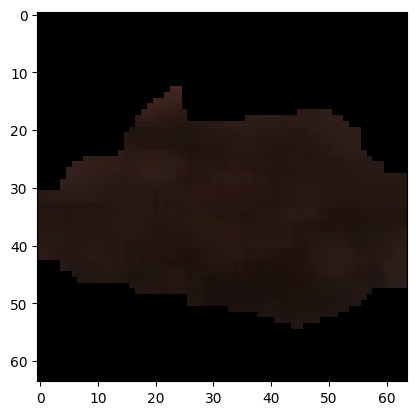

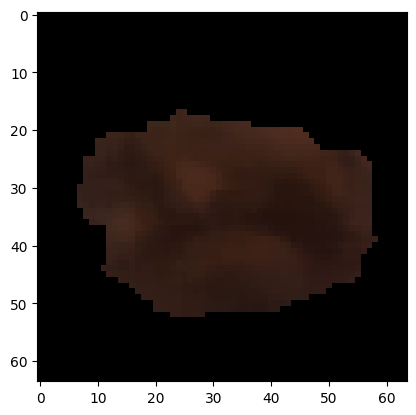

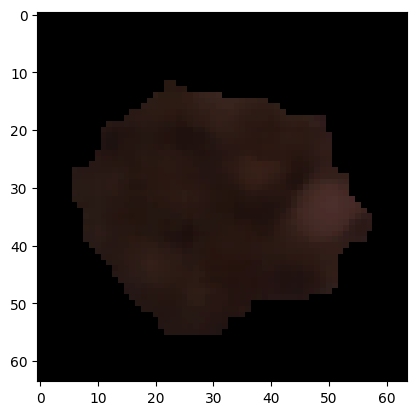

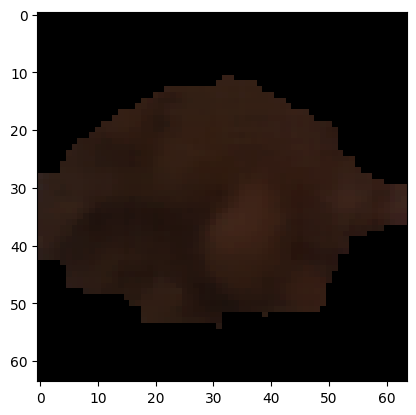

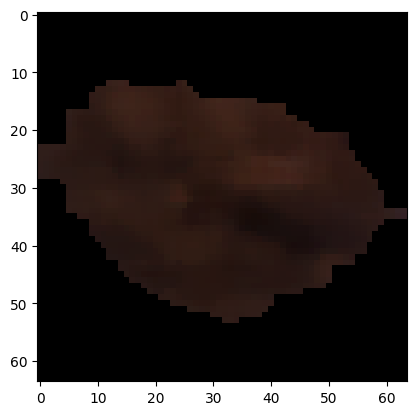

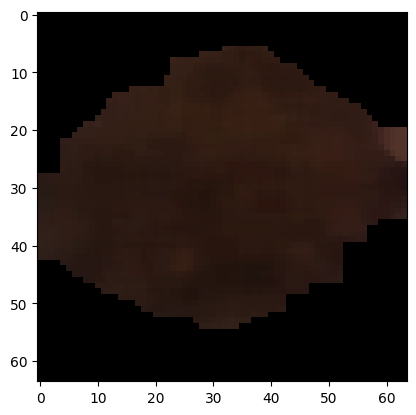

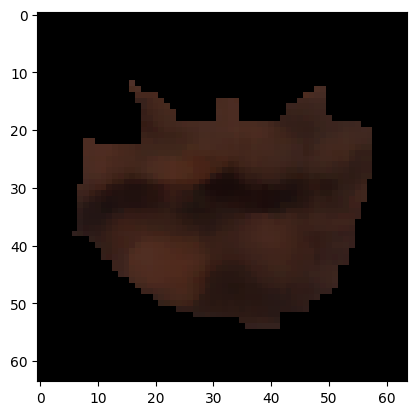

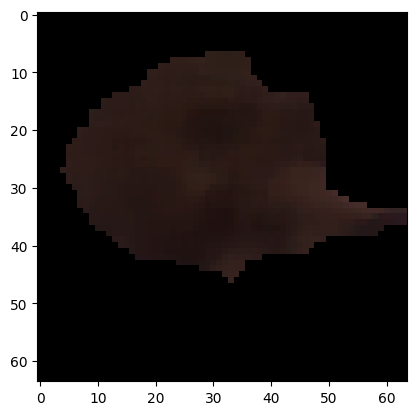

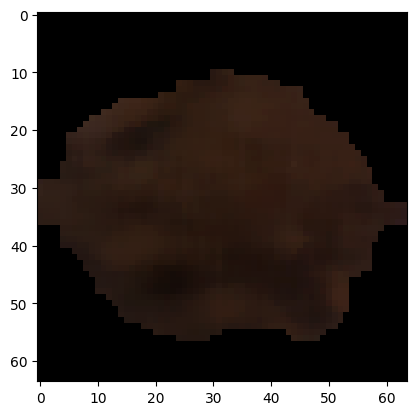

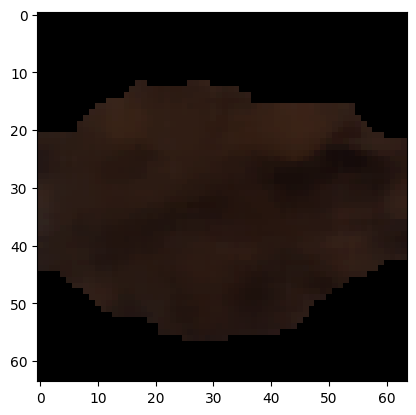

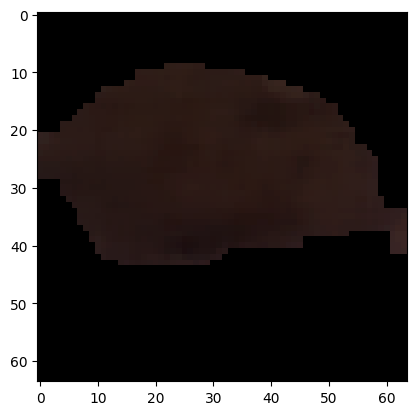

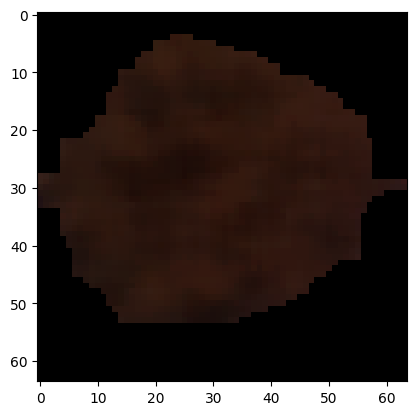

In [24]:
for x,i in enumerate(SAMPLE):
    plt.imshow(i)
    plt.show()
    if x == 20:
        break

In [25]:
np.array(y_values_1).shape

(80, 2, 4, 64, 64)

In [26]:
np.array(y_train).shape

(320, 2, 64, 64)

In [27]:
np.array(SAMPLE_TRAIN).shape

(320, 64, 64, 3)

In [28]:
unprocess_label_wmask(SAMPLE_TRAIN[3],np.array(SAMPLE_TRAIN_Y)[3])

[0.29999999999999993, 4.78000020980835]

In [29]:
x_col = "path"
y_col = "pH"
batch_size = 16
epochs = 1024
lr = 1e-5
image_size = (IMAGE_SIZE[0],IMAGE_SIZE[1])
channels = 3
shuffle = True
class_mode ="raw"
color_mode = "rgb"

# Evaluation of Designs

In [30]:
# import tensorflow as tf
# from tensorflow.keras import backend as K

# def mean_squared_error(y_true, y_pred):
#     y_pred = tf.convert_to_tensor(y_pred)
#     y_true = tf.cast(y_true, y_pred.dtype)
#     return K.mean(tf.math.squared_difference(y_pred, y_true), axis=[1,2])

# def mean_absolute_error(y_true, y_pred):
#     y_pred = tf.convert_to_tensor(y_pred)
#     y_true = tf.cast(y_true, y_pred.dtype)
#     return K.mean(tf.abs(y_pred - y_true), axis=[1,2])


In [31]:
import tensorflow as tf
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    # y_pred = tf.convert_to_tensor(y_pred)
    # y_true = tf.cast(y_true, y_pred.dtype)
    
    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())

    # # Create mask based on non-zero values of y_true
    # mask = tf.cast(y_true != 0, y_pred.dtype)
    
    # # Apply mask to y_true and y_pred
    # y_true = y_true * mask
    # y_pred = y_pred * mask
    
    return K.sqrt(K.mean(tf.square(y_pred - y_true), axis=None))

def mean_squared_error(y_true, y_pred):

    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())

    return K.mean(tf.math.squared_difference(y_pred, y_true), axis=None)

def mean_absolute_error(y_true, y_pred):

    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())

    return K.mean(tf.abs(y_pred - y_true), axis=None)

def huber_ph(y_true, y_pred, delta=1.0):
    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())
    
    delta = tf.cast(delta, dtype=K.floatx())
    error = tf.subtract(y_pred, y_true)
    abs_error = tf.abs(error)
    half = tf.convert_to_tensor(0.5, dtype=abs_error.dtype)
    return K.mean(
        tf.where(
            abs_error <= delta,
            half * tf.square(error),
            delta * abs_error - half * tf.square(delta),
        ),
        axis=None,
    )
def huber_moisture(y_true, y_pred, delta=5.0):
    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())

    delta = tf.cast(delta, dtype=K.floatx())
    error = tf.subtract(y_pred, y_true)
    abs_error = tf.abs(error)
    half = tf.convert_to_tensor(1.0, dtype=abs_error.dtype)
    return K.mean(
        tf.where(
            abs_error <= delta,
            half * tf.square(error),
            delta * abs_error - half * tf.square(delta),
        ),
        axis=None,
    )


## Optimization of Designs

### Design A

In [32]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout, Concatenate, Flatten, Dense, Reshape
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.initializers import HeNormal

# def convolution_block(inputs, num_filters, kernel_size=3, padding="same", use_bias=False):
#     x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     return x

# def upsample_block(inputs, skip_features, num_filters):
#     x = UpSampling2D((2, 2))(inputs)
#     x = Conv2D(num_filters, (2, 2), padding="same")(x)
#     x = Concatenate()([x, skip_features])
#     x = convolution_block(x, num_filters)
#     return x

# def unet_plus_plus_model(hp, input_shape=(64, 64, 3)):
#     inputs = Input(input_shape)

#     resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
#     resnet50.trainable = True

#     # Encoder
#     s1 = resnet50.get_layer("conv1_relu").output
#     s2 = resnet50.get_layer("conv2_block3_out").output
#     s3 = resnet50.get_layer("conv3_block4_out").output
#     s4 = resnet50.get_layer("conv4_block6_out").output
#     b1 = resnet50.get_layer("conv5_block3_out").output

#     # Flatten the bottleneck output
#     x = Flatten()(b1)
#     UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
#     DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)
#     BATCHNORM = hp.Boolean('batchnorm', default=False)

#     # Dense layers between encoder and decoder
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
    
#     # Reshape back to spatial dimensions for the decoder
#     SIZE = input_shape[0] // 16  # Assuming input size is a multiple of 16
#     if BATCHNORM:
#         x = BatchNormalization()(x)
#     x = Dense(SIZE * SIZE * 2048, activation='relu')(x)
#     x = Reshape((SIZE, SIZE, 2048))(x)

#     # Nested Decoding Path
#     x_01_moisture = upsample_block(s2, s1, 64)
#     x_11_moisture = upsample_block(s3, s2, 128)
#     x_21_moisture = upsample_block(s4, s3, 256)
#     x_31_moisture = upsample_block(x, s4, 512)

#     x_02_moisture = upsample_block(x_11_moisture, x_01_moisture, 64)
#     x_12_moisture = upsample_block(x_21_moisture, x_11_moisture, 128)
#     x_22_moisture = upsample_block(x_31_moisture, x_21_moisture, 256)

#     x_03_moisture = upsample_block(x_12_moisture, x_02_moisture, 64)
#     x_13_moisture = upsample_block(x_22_moisture, x_12_moisture, 128)

#     x_04_moisture = upsample_block(x_13_moisture, x_03_moisture, 64)

#     x_01_ph = upsample_block(s2, s1, 64)
#     x_11_ph = upsample_block(s3, s2, 128)
#     x_21_ph = upsample_block(s4, s3, 256)
#     x_31_ph = upsample_block(x, s4, 512)

#     x_02_ph = upsample_block(x_11_ph, x_01_ph, 64)
#     x_12_ph = upsample_block(x_21_ph, x_11_ph, 128)
#     x_22_ph = upsample_block(x_31_ph, x_21_ph, 256)

#     x_03_ph = upsample_block(x_12_ph, x_02_ph, 64)
#     x_13_ph = upsample_block(x_22_ph, x_12_ph, 128)

#     x_04_ph = upsample_block(x_13_ph, x_03_ph, 64)

#     ph_output = Conv2D(1, (1, 1), activation="linear", name="ph_output")(x_04_ph)
#     moisture_output = Conv2D(1, (1, 1), activation="linear", name="moisture_output")(x_04_moisture)

#     model = tf.keras.Model(inputs=inputs, outputs=[ph_output, moisture_output], name='Unet_plus_plus')

#     optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

#     if optimizer_choice == 'sgd':
#         optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
#     elif optimizer_choice == 'rmsprop':
#         optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
#     else:
#         optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#     model.compile(optimizer=optimizer, 
#                   loss={"moisture_output": huber_moisture, "ph_output": huber_ph}, 
#                   metrics={"moisture_output": [root_mean_squared_error, mean_absolute_error], "ph_output": [root_mean_squared_error, mean_absolute_error]},
#                   loss_weights={'moisture_output': 1.0, 'ph_output': 0.7})
#     return model


In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Concatenate,Reshape
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal

def conv_block(inputs, num_filters, kernel_size=3, padding='same', use_bias=False):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, use_bias=use_bias, kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_plus_plus_model(hp, input_shape=(64, 64, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    
    # Using ResNet50 as the encoder
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50.trainable = False

    # Encoder path
    s1 = resnet50.get_layer("conv1_relu").output
    s2 = resnet50.get_layer("conv2_block3_out").output
    s3 = resnet50.get_layer("conv3_block4_out").output
    s4 = resnet50.get_layer("conv4_block6_out").output
    b1 = resnet50.get_layer("conv5_block3_out").output
    
    # Flatten the bottleneck output
    x = Flatten()(b1)
    UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm', default=False)

    # Dense layers between encoder and decoder
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    
    # Reshape back to spatial dimensions for the decoder
    SIZE = input_shape[0] // 32  # Assuming input size is a multiple of 16
    if BATCHNORM:
        x = BatchNormalization()(x)
    x = Dense(SIZE * SIZE * 1024, activation='relu')(x)
    x = Reshape((SIZE, SIZE, 1024))(x)

    # Nested Decoding Path
    x_01_moisture = conv_block(Concatenate()([s1, UpSampling2D()(s2)]), 32)
    x_11_moisture = conv_block(Concatenate()([s2, UpSampling2D()(s3)]), 64)
    x_21_moisture = conv_block(Concatenate()([s3, UpSampling2D()(s4)]), 128)
    x_31_moisture = conv_block(Concatenate()([s4, UpSampling2D()(x)]), 256)

    x_02_moisture = conv_block(Concatenate()([s1, x_01_moisture, UpSampling2D()(x_11_moisture)]), 32)
    x_12_moisture = conv_block(Concatenate()([s2, x_11_moisture, UpSampling2D()(x_21_moisture)]), 64)
    x_22_moisture = conv_block(Concatenate()([s3, x_21_moisture, UpSampling2D()(x_31_moisture)]), 128)

    x_03_moisture = conv_block(Concatenate()([s1, x_01_moisture, x_02_moisture, UpSampling2D()(x_12_moisture)]), 32)
    x_13_moisture = conv_block(Concatenate()([s2, x_11_moisture, x_12_moisture, UpSampling2D()(x_22_moisture)]), 64)

    x_04_moisture = conv_block(Concatenate()([s1, x_01_moisture, x_02_moisture, x_03_moisture, UpSampling2D()(x_13_moisture)]), 32)

    # Nested Decoding Path
    x_01_ph = conv_block(Concatenate()([s1, UpSampling2D()(s2)]), 32)
    x_11_ph = conv_block(Concatenate()([s2, UpSampling2D()(s3)]), 64)
    x_21_ph = conv_block(Concatenate()([s3, UpSampling2D()(s4)]), 128)
    x_31_ph = conv_block(Concatenate()([s4, UpSampling2D()(x)]), 256)

    x_02_ph = conv_block(Concatenate()([s1, x_01_ph, UpSampling2D()(x_11_ph)]), 32)
    x_12_ph = conv_block(Concatenate()([s2, x_11_ph, UpSampling2D()(x_21_ph)]), 64)
    x_22_ph = conv_block(Concatenate()([s3, x_21_ph, UpSampling2D()(x_31_ph)]), 128)

    x_03_ph = conv_block(Concatenate()([s1, x_01_ph, x_02_ph, UpSampling2D()(x_12_ph)]), 32)
    x_13_ph = conv_block(Concatenate()([s2, x_11_ph, x_12_ph, UpSampling2D()(x_22_ph)]), 64)

    x_04_ph = conv_block(Concatenate()([s1, x_01_ph, x_02_ph, x_03_ph, UpSampling2D()(x_13_ph)]), 32)

    # moisture_output = tf.keras.layers.UpSampling2D()(x_04_moisture)
    # ph_output = tf.keras.layers.UpSampling2D()(x_04_ph)

    # moisture_output = Conv2D(1, 1, activation="linear", name="moisture_output")(moisture_output)
    # ph_output = Conv2D(1, 1, activation="linear", name="ph_output")(ph_output)
    
    # Output layer for moisture
    y1 = layers.Dropout(0.5)(x_04_moisture)
    moisture_output = layers.Conv2DTranspose(1, (3, 3),2, padding='same', activation="linear", name='moisture_output')(y1)
    # print(moisture_output.shape)
    # moisture_output = layers.Conv2DTranspose(1, (3, 3), padding='same')(y1)
    # moisture_output = layers.BatchNormalization()(moisture_output)
    # moisture_output = layers.ReLU(name='moisture_output')(moisture_output)
    
    # Output layer for ph_output
    y2 = layers.Dropout(0.5)(x_04_ph)
    ph_output = layers.Conv2DTranspose(1, (3, 3),2, padding='same', activation="linear", name='ph_output')(y2)
    # ph_output = layers.Conv2DTranspose(1, (3, 3), padding='same')(y2)
    # ph_output = layers.BatchNormalization()(ph_output)
    # ph_output = layers.ReLU(name='ph_output')(ph_output)
    
    model = tf.keras.Model(inputs=inputs, outputs=[moisture_output, ph_output], name='NestedUNet')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, 
                    loss={"moisture_output":huber_moisture, "ph_output":huber_ph}, 
                    metrics={"moisture_output":[mean_absolute_error, mean_squared_error],"ph_output":[mean_absolute_error, mean_squared_error]},
                    loss_weights={'moisture_output': 1.0, 'ph_output': 0.7}
                    )
    return model



In [33]:
tunerA = kt.BayesianOptimization(unet_plus_plus_model,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_a',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

tunerA.search(train_generator, epochs=50, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsA=tunerA.get_best_hyperparameters(num_trials=1)[0]


print(best_hpsA.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_a\tuner0.json
{'units': 2048, 'dropout': 0.30000000000000004, 'batchnorm': True, 'optimizer': 'adam', 'learning_rate': 0.001}


In [34]:
modelA = unet_plus_plus_model(best_hpsA)
modelA.summary()

Model: "NestedUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                         

In [606]:
import time 
training_arrayA = []
for i in range(10):
    modelA = unet_plus_plus_model(best_hpsA)
    start = time.time()
    historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=0, callbacks = [ES, REDUCE_LR])
    stop = time.time()
    training_arrayA.append(stop - start)
    print(f"Training time: {stop - start}s")
print("Final Training Time: {}".format(sum(training_arrayA)/len(training_arrayA)))

KeyboardInterrupt: 

In [ ]:
## DESIGN A
import time 
modelA = unet_plus_plus_model(best_hpsA)
start = time.time()
historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=1, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
79/79 [==============================] - 15s 115ms/step - loss: 2.2011 - moisture_output_loss: 1.3549 - ph_output_loss: 1.2088 - moisture_output_mean_absolute_error: 0.8738 - moisture_output_mean_squared_error: 1.3561 - ph_output_mean_absolute_error: 1.5500 - ph_output_mean_squared_error: 5.0505 - val_loss: 3.2052 - val_moisture_output_loss: 1.9985 - val_ph_output_loss: 1.7238 - val_moisture_output_mean_absolute_error: 1.0742 - val_moisture_output_mean_squared_error: 2.0148 - val_ph_output_mean_absolute_error: 2.1549 - val_ph_output_mean_squared_error: 7.4761 - lr: 0.0010
Epoch 2/1024
79/79 [==============================] - 6s 78ms/step - loss: 1.3909 - moisture_output_loss: 0.9102 - ph_output_loss: 0.6867 - moisture_output_mean_absolute_error: 0.7071 - moisture_output_mean_squared_error: 0.9102 - ph_output_mean_absolute_error: 0.9825 - ph_output_mean_squared_error: 2.5726 - val_loss: 3.8987 - val_moisture_output_loss: 2.6719 - val_ph_output_loss: 1.7525 - val_moisture_ou

In [ ]:
# truths = []
# preds = []
# for i in range(TRAIN_RANGE):
#     predictions = modelA.predict(np.array([SAMPLE_TRAIN[i]]))
#     truths.append(unprocess_label_wmask(SAMPLE_TRAIN[i],SAMPLE_TRAIN_Y[i]))
#     preds.append(unprocess_label_wmask(SAMPLE_TRAIN[i],predictions))
# truths_moisture = [round(truth[0],2) for truth in truths]
# truths_ph = [round(truth[1],2) for truth in truths]
# preds_moisture = [round(pred[0],2) for pred in preds]
# preds_ph = [round(pred[1],2) for pred in preds]


# for i in range(len(truths_moisture)):
#     print(i, end=" ")
#     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
#     print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# plt.figure(figsize=(12, 6))

# # Moisture Plot
# plt.subplot(2, 1, 1)
# plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
# plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
# plt.title('Moisture Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('Moisture')
# plt.legend()

# # pH Plot
# plt.subplot(2, 1, 2)
# plt.plot(truths_ph, label='Truths - pH', marker='o')
# plt.plot(preds_ph, label='Preds - pH', marker='x')
# plt.title('pH Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('pH')
# plt.legend()

# plt.tight_layout()
# plt.show()

# def accuracy(truth, pred):
#     return (1 - abs(truth - pred) / truth) * 100

# TEMP_0 = []
# TEMP_1 = []
# for i in range(len(truths_moisture)):
#     TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
#     TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
# print(np.mean(np.array(TEMP_0)))
# print(np.mean(np.array(TEMP_1)))


In [ ]:

# truths = []
# preds = []
# for i in range(20):
#     predictions = modelA.predict(np.array([SAMPLE[i]]))
#     truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
#     preds.append(unprocess_label_wmask(SAMPLE[i],predictions))
# truths_moisture = [truth[0] for truth in truths]
# truths_ph = [truth[1] for truth in truths]
# preds_moisture = [pred[0] for pred in preds]
# preds_ph = [pred[1] for pred in preds]

# for i in range(len(truths_moisture)):
#     print(i, end=" ")
#     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
#     print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# plt.figure(figsize=(12, 6))

# # Moisture Plot
# plt.subplot(2, 1, 1)
# plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
# plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
# plt.title('Moisture Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('Moisture')
# plt.legend()

# # pH Plot
# plt.subplot(2, 1, 2)
# plt.plot(truths_ph, label='Truths - pH', marker='o')
# plt.plot(preds_ph, label='Preds - pH', marker='x')
# plt.title('pH Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('pH')
# plt.legend()

# plt.tight_layout()
# plt.show()

# def accuracy(truth, pred):
#     return (1 - abs(truth - pred) / truth) * 100

# TEMP_0 = []
# TEMP_1 = []
# for i in range(len(truths_moisture)):
#     TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
#     TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
# print(np.mean(np.array(TEMP_0)))
# print(np.mean(np.array(TEMP_1)))



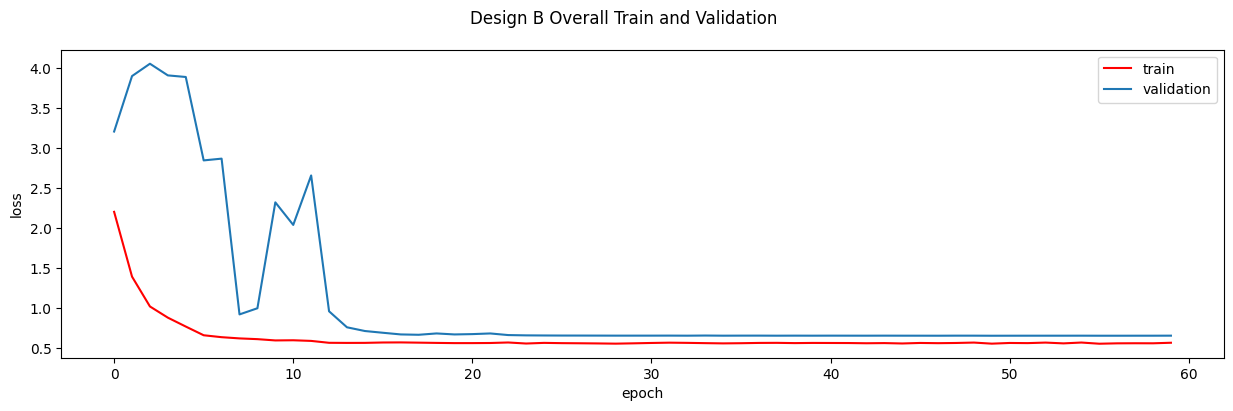

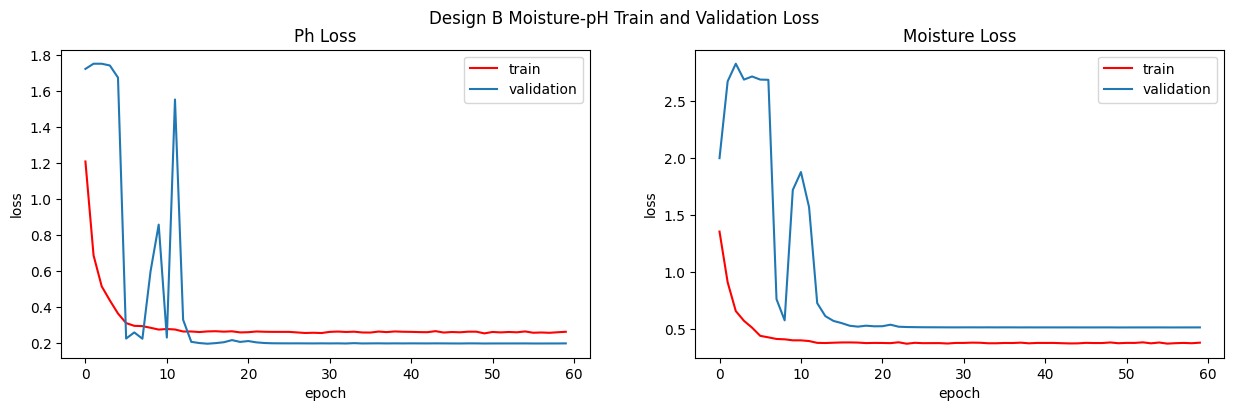

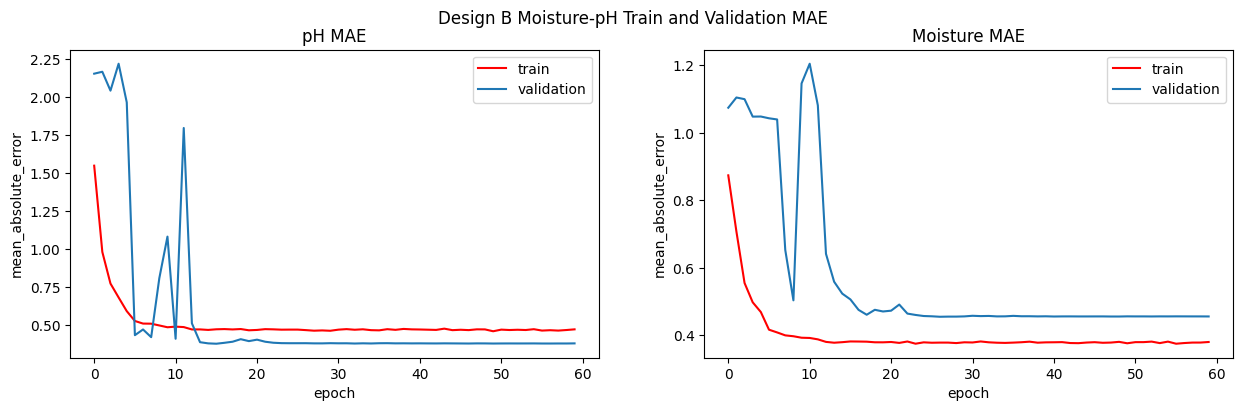

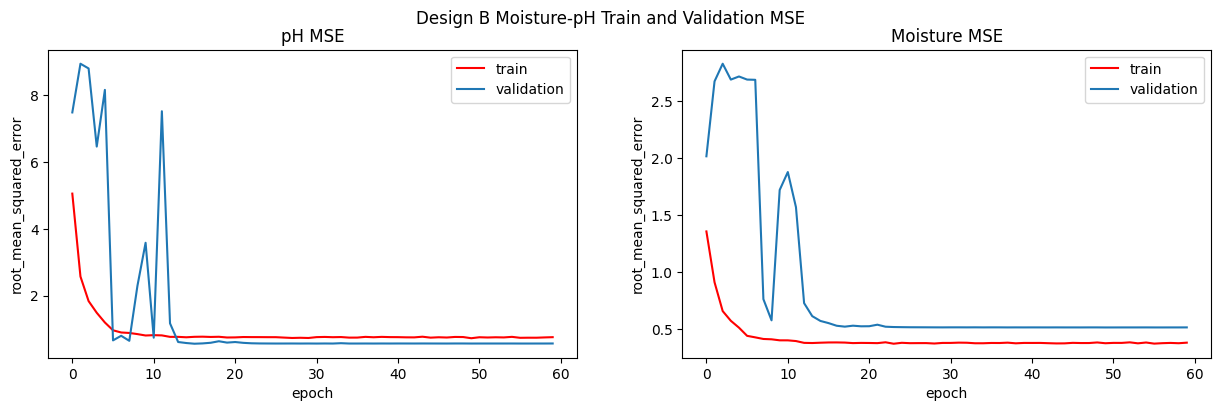

In [ ]:
## Graphing Result of training
HISTORY = historyA


plt.figure(figsize=(15,4))
plt.suptitle("Design B Overall Train and Validation")

plt.subplot(111)
plt.plot(HISTORY.history['loss'], color ='r')
plt.plot(HISTORY.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation Loss")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_loss'], color ='r')
plt.plot(HISTORY.history['val_ph_output_loss'])
plt.title('Ph Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_loss'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_loss'])
plt.title('Moisture Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation MAE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_absolute_error'])
plt.title('pH MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_absolute_error'])
plt.title('Moisture MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation MSE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_squared_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_squared_error'])
plt.title('pH MSE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('root_mean_squared_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_squared_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_squared_error'])
plt.title('Moisture MSE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('root_mean_squared_error')

# displaying the figure
plt.show()

In [ ]:
## Design A
history = historyA.history

loss_keys = [key for key in history.keys() if 'loss' in key]
metric_keys = [key for key in history.keys() if 'error' in key]

val_loss = history['val_loss']
best_epoch = np.argmin(val_loss)

print("Best Epoch: ", best_epoch)

for key in loss_keys + metric_keys:
    if key.startswith('val_'):
        metric_name = key[4:] 
        final_value = history[key][best_epoch]
        print(f"Final Validation {metric_name}: {final_value:.4f}")
    else:
        final_value = history[key][best_epoch]
        print(f"Final Train {key}: {final_value:.4f}")


Best Epoch:  49
Final Train loss: 0.5529
Final Train moisture_output_loss: 0.3759
Final Train ph_output_loss: 0.2529
Final Validation loss: 0.6518
Final Validation moisture_output_loss: 0.5142
Final Validation ph_output_loss: 0.1966
Final Train moisture_output_mean_absolute_error: 0.3760
Final Train moisture_output_mean_squared_error: 0.3759
Final Train ph_output_mean_absolute_error: 0.4612
Final Train ph_output_mean_squared_error: 0.7289
Final Validation moisture_output_mean_absolute_error: 0.4559
Final Validation moisture_output_mean_squared_error: 0.5142
Final Validation ph_output_mean_absolute_error: 0.3805
Final Validation ph_output_mean_squared_error: 0.5703


In [ ]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [ ]:
# modelA.save('design_models_v2/designA_v6.h5')


### Design B

In [ ]:
### 94 95 acc

# # import tensorflow as tf
# # from tensorflow.keras import layers, Model
# # from tensorflow.keras.applications import VGG16
# from tensorflow.keras.regularizers import l2
# def segnet(hp, input_shape=(64, 64, 3), num_classes=2):
#     # Load the VGG16 model with batch normalization
#     vgg16_bn = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#     vgg16_bn.trainable = False
    
#     ## DITO KO LALAGAY
    
#     # Encoder
#     inputs = layers.Input(shape=input_shape)

#     # Using the pretrained VGG16_bn layers
#     x = vgg16_bn.get_layer('block1_conv1')(inputs)
#     x = vgg16_bn.get_layer('block1_conv2')(x)
#     stage1 = x
#     x = vgg16_bn.get_layer('block1_pool')(x)

#     x = vgg16_bn.get_layer('block2_conv1')(x)
#     x = vgg16_bn.get_layer('block2_conv2')(x)
#     stage2 = x
#     x = vgg16_bn.get_layer('block2_pool')(x)

#     x = vgg16_bn.get_layer('block3_conv1')(x)
#     x = vgg16_bn.get_layer('block3_conv2')(x)
#     x = vgg16_bn.get_layer('block3_conv3')(x)
#     stage3 = x
#     x = vgg16_bn.get_layer('block3_pool')(x)

#     x = vgg16_bn.get_layer('block4_conv1')(x)
#     x = vgg16_bn.get_layer('block4_conv2')(x)
#     x = vgg16_bn.get_layer('block4_conv3')(x)
#     stage4 = x
#     x = vgg16_bn.get_layer('block4_pool')(x)

#     x = vgg16_bn.get_layer('block5_conv1')(x)
#     x = vgg16_bn.get_layer('block5_conv2')(x)
#     x = vgg16_bn.get_layer('block5_conv3')(x)
#     stage5 = x
#     x = vgg16_bn.get_layer('block5_pool')(x)

#     UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256)
#     DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
#     BATCHNORM = hp.Boolean('batchnorm',default=False)
    
#     # Dense layers between encoder and decoder
#     x = layers.Flatten()(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     x = Dropout(DROPOUT)(x)
#     x = Dense(UNITS, activation='relu')(x)
#     if BATCHNORM:
#         x = BatchNormalization()(x)
#     SIZE = input_shape[0]//32
#     x = layers.Dense(SIZE*SIZE*512, activation='relu')(x)  # Adjust to match the new dimensions
#     x = layers.Reshape((SIZE, SIZE, 512))(x)  # Adjust to match the new dimensions

#     # Decoder for moisture_output
#     y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.UpSampling2D()(y1)

#     # Incorporate stage5
#     y1 = layers.Concatenate()([y1, stage5])
#     y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.UpSampling2D()(y1)

#     # Incorporate stage4
#     y1 = layers.Concatenate()([y1, stage4])
#     y1 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.Conv2DTranspose(64, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.UpSampling2D()(y1)

#     # Incorporate stage3
#     y1 = layers.Concatenate()([y1, stage3])
#     y1 = layers.Conv2DTranspose(64, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.UpSampling2D()(y1)

#     # Incorporate stage2
#     y1 = layers.Concatenate()([y1, stage2])
#     y1 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
#     y1 = layers.UpSampling2D()(y1)

#     # Incorporate stage1
#     y1 = layers.Concatenate()([y1, stage1])
#     y1 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y1)
#     y1 = layers.BatchNormalization()(y1)
#     y1 = layers.ReLU()(y1)
    
#     # Decoder for ph_output
#     y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.UpSampling2D()(y2)
    
#     y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.UpSampling2D()(y2)

#     # Incorporate stage5
#     y2 = layers.Concatenate()([y2, stage5])
#     y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.UpSampling2D()(y2)

#     # Incorporate stage4
#     y2 = layers.Concatenate()([y2, stage4])
#     y2 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(64, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.UpSampling2D()(y2)

#     # Incorporate stage3
#     y2 = layers.Concatenate()([y2, stage3])
#     y2 = layers.Conv2DTranspose(64, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.UpSampling2D()(y2)

#     # Incorporate stage2
#     y2 = layers.Concatenate()([y2, stage2])
#     y2 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)
#     y2 = layers.UpSampling2D()(y2)

#     # Incorporate stage1
#     y2 = layers.Concatenate()([y2, stage1])
#     y2 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y2)
#     y2 = layers.BatchNormalization()(y2)
#     y2 = layers.ReLU()(y2)

#     # Output layer for moisture
#     moisture_output = layers.Conv2DTranspose(1, (3, 3), padding='same')(y1)
#     moisture_output = layers.BatchNormalization()(moisture_output)
#     moisture_output = layers.ReLU(name='moisture_output')(moisture_output)
    
#     # Output layer for ph_output
#     ph_output = layers.Conv2DTranspose(1, (3, 3), padding='same')(y2)
#     ph_output = layers.BatchNormalization()(ph_output)
#     ph_output = layers.ReLU(name='ph_output')(ph_output)
    
    
    
#     # Outputs
#     # outputs1 = layers.Conv2DTranspose(1, (3, 3), padding="same", activation="linear", name="moisture_output")(x)
#     # outputs1 = layers.BatchNormalization()(outputs1)
#     # outputs1 = layers.ReLU()(x)
    
#     # outputs2 = layers.Conv2DTranspose(1, (3, 3), padding="same", activation="linear", name="ph_output")(x)
#     # outputs2 = layers.BatchNormalization()(outputs1)
#     # outputs2 = layers.ReLU()(x)
    
#     # x = layers.Dropout(0.5)(x)
    
#     # outputs1 = Conv2D(1, (1, 1), padding="same", activation="linear", name="moisture_output")(x)
#     # outputs2 = Conv2D(1, (1, 1), padding="same", activation="linear", name="ph_output")(x)
#     model = tf.keras.Model(inputs=inputs, outputs=[moisture_output, ph_output], name='SegNet')

#     optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

#     if optimizer_choice == 'sgd':
#         optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
#     elif optimizer_choice == 'rmsprop':
#         optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
#     else:
#         optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#     model.compile(optimizer=optimizer, 
#                     loss={"moisture_output":huber, "ph_output":huber}, 
#                     metrics={"moisture_output":[mean_absolute_error, root_mean_squared_error],"ph_output":[mean_absolute_error, root_mean_squared_error]},
#                     loss_weights={'moisture_output': 1.0, 'ph_output': 0.5}
#                     )
#     return model



In [33]:


# import tensorflow as tf
# from tensorflow.keras import layers, Model
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
def segnet(hp, input_shape=(64, 64, 3), num_classes=2):
    # Load the VGG16 model with batch normalization
    vgg16_bn = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg16_bn.trainable = False
    
    ## DITO KO LALAGAY
    
    # Encoder
    inputs = layers.Input(shape=input_shape)

    # Using the pretrained VGG16_bn layers
    x = vgg16_bn.get_layer('block1_conv1')(inputs)
    x = vgg16_bn.get_layer('block1_conv2')(x)
    stage1 = x
    x = vgg16_bn.get_layer('block1_pool')(x)

    x = vgg16_bn.get_layer('block2_conv1')(x)
    x = vgg16_bn.get_layer('block2_conv2')(x)
    stage2 = x
    x = vgg16_bn.get_layer('block2_pool')(x)

    x = vgg16_bn.get_layer('block3_conv1')(x)
    x = vgg16_bn.get_layer('block3_conv2')(x)
    x = vgg16_bn.get_layer('block3_conv3')(x)
    stage3 = x
    x = vgg16_bn.get_layer('block3_pool')(x)

    x = vgg16_bn.get_layer('block4_conv1')(x)
    x = vgg16_bn.get_layer('block4_conv2')(x)
    x = vgg16_bn.get_layer('block4_conv3')(x)
    stage4 = x
    x = vgg16_bn.get_layer('block4_pool')(x)

    x = vgg16_bn.get_layer('block5_conv1')(x)
    x = vgg16_bn.get_layer('block5_conv2')(x)
    x = vgg16_bn.get_layer('block5_conv3')(x)
    stage5 = x
    x = vgg16_bn.get_layer('block5_pool')(x)

    UNITS = hp.Choice('units',values = [256,512,1024,2048], default=256)
    DROPOUT = hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm',default=False)
    
    # Dense layers between encoder and decoder
    x = layers.Flatten()(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    x = Dropout(DROPOUT)(x)
    x = Dense(UNITS, activation='relu')(x)
    if BATCHNORM:
        x = BatchNormalization()(x)
    SIZE = input_shape[0]//32
    x = layers.Dense(SIZE*SIZE*512, activation='relu')(x)  # Adjust to match the new dimensions
    x = layers.Reshape((SIZE, SIZE, 512))(x)  # Adjust to match the new dimensions

    # Decoder for moisture_output
    y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.UpSampling2D()(y1)

    # Incorporate stage5
    y1 = layers.Concatenate()([y1, stage5])
    y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.UpSampling2D()(y1)

    # Incorporate stage4
    y1 = layers.Concatenate()([y1, stage4])
    y1 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.Conv2DTranspose(64, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.UpSampling2D()(y1)

    # Incorporate stage3
    y1 = layers.Concatenate()([y1, stage3])
    y1 = layers.Conv2DTranspose(64, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.UpSampling2D()(y1)

    # Incorporate stage2
    y1 = layers.Concatenate()([y1, stage2])
    y1 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    y1 = layers.UpSampling2D()(y1)

    # Incorporate stage1
    y1 = layers.Concatenate()([y1, stage1])
    y1 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y1)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)
    
    # Decoder for ph_output
    y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(x)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.UpSampling2D()(y2)

    # Incorporate stage5
    y2 = layers.Concatenate()([y2, stage5])
    y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.Conv2DTranspose(256, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.UpSampling2D()(y2)

    # Incorporate stage4
    y2 = layers.Concatenate()([y2, stage4])
    y2 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.Conv2DTranspose(128, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.Conv2DTranspose(64, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.UpSampling2D()(y2)

    # Incorporate stage3
    y2 = layers.Concatenate()([y2, stage3])
    y2 = layers.Conv2DTranspose(64, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.UpSampling2D()(y2)

    # Incorporate stage2
    y2 = layers.Concatenate()([y2, stage2])
    y2 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)
    y2 = layers.UpSampling2D()(y2)

    # Incorporate stage1
    y2 = layers.Concatenate()([y2, stage1])
    y2 = layers.Conv2DTranspose(32, (3, 3), padding='same')(y2)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)

    # Output layer for moisture
    y1 = layers.Dropout(0.5)(y1)
    moisture_output = layers.Conv2DTranspose(1, (3, 3), padding='same', activation="linear", name='moisture_output')(y1)
    # moisture_output = layers.Conv2DTranspose(1, (3, 3), padding='same')(y1)
    # moisture_output = layers.BatchNormalization()(moisture_output)
    # moisture_output = layers.ReLU(name='moisture_output')(moisture_output)
    
    # Output layer for ph_output
    y2 = layers.Dropout(0.5)(y2)
    ph_output = layers.Conv2DTranspose(1, (3, 3), padding='same', activation="linear", name='ph_output')(y2)
    # ph_output = layers.Conv2DTranspose(1, (3, 3), padding='same')(y2)
    # ph_output = layers.BatchNormalization()(ph_output)
    # ph_output = layers.ReLU(name='ph_output')(ph_output)
    
    model = tf.keras.Model(inputs=inputs, outputs=[moisture_output, ph_output], name='SegNet')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, 
                    loss={"moisture_output":huber_moisture, "ph_output":huber_ph}, 
                    metrics={"moisture_output":[mean_absolute_error, mean_squared_error],"ph_output":[mean_absolute_error, mean_squared_error]},
                    loss_weights={'moisture_output': 1.0, 'ph_output': 0.7}
                    )
    return model



In [34]:
tunerB = kt.BayesianOptimization(segnet,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_b',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)


tunerB.search(train_generator, epochs=30, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsB=tunerB.get_best_hyperparameters(num_trials=1)[0]



print(best_hpsB.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_b\tuner0.json
{'units': 1024, 'dropout': 0.2, 'batchnorm': False, 'optimizer': 'rmsprop', 'learning_rate': 0.001}


In [35]:
# Build the model with the best hp.
modelB = segnet(best_hpsB)
modelB.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[1][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[1][0]']           
                                                                                             

In [36]:
# import time 
# training_arrayB = []
# for i in range(10):
#     modelB = segnet(best_hpsB)
#     start = time.time()
#     historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=0, callbacks = [ES, REDUCE_LR])
#     stop = time.time()
#     training_arrayB.append(stop - start)
#     print(f"Training time: {stop - start}s")
# print("Final Training Time: {}".format(sum(training_arrayB)/len(training_arrayB)))

In [37]:
## DESIGN B
import time 
# modelB = segnet(best_hpsB)
start = time.time()
historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/1024
80/80 - 15s - loss: 0.9110 - moisture_output_loss: 0.6406 - ph_output_loss: 0.3863 - moisture_output_mean_absolute_error: 0.5762 - moisture_output_mean_squared_error: 0.6494 - ph_output_mean_absolute_error: 0.6825 - ph_output_mean_squared_error: 1.1500 - val_loss: 42.1968 - val_moisture_output_loss: 35.8892 - val_ph_output_loss: 9.0108 - val_moisture_output_mean_absolute_error: 12.0940 - val_moisture_output_mean_squared_error: 151.4252 - val_ph_output_mean_absolute_error: 9.5107 - val_ph_output_mean_squared_error: 93.8901 - lr: 0.0010 - 15s/epoch - 184ms/step
Epoch 2/1024
80/80 - 6s - loss: 0.5235 - moisture_output_loss: 0.3775 - ph_output_loss: 0.2086 - moisture_output_mean_absolute_error: 0.4213 - moisture_output_mean_squared_error: 0.3775 - ph_output_mean_absolute_error: 0.4475 - ph_output_mean_squared_error: 0.4968 - val_loss: 19.8610 - val_moisture_output_loss: 15.0746 - val_ph_output_loss: 6.8377 - val_moisture_output_mean_absolute_error: 7.5879 - val_moisture_output

In [38]:
# ## DESIGN B
# import time 
# start = time.time()
# historyB_2 = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
# stop = time.time()
# print(f"Training time: {stop - start}s")

In [39]:
# truths = []
# preds = []
# for i in range(TRAIN_RANGE):
#     predictions = modelB.predict(np.array([SAMPLE_TRAIN[i]]))
#     truths.append(unprocess_label_wmask(SAMPLE_TRAIN[i],SAMPLE_TRAIN_Y[i]))
#     preds.append(unprocess_label_wmask(SAMPLE_TRAIN[i],predictions))
# truths_moisture = [round(truth[0],2) for truth in truths]
# truths_ph = [round(truth[1],2) for truth in truths]
# preds_moisture = [round(pred[0],2) for pred in preds]
# preds_ph = [round(pred[1],2) for pred in preds]


# for i in range(len(truths_moisture)):
#     print(i, end=" ")
#     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
#     print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# plt.figure(figsize=(12, 6))

# # Moisture Plot
# plt.subplot(2, 1, 1)
# plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
# plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
# plt.title('Moisture Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('Moisture')
# plt.legend()

# # pH Plot
# plt.subplot(2, 1, 2)
# plt.plot(truths_ph, label='Truths - pH', marker='o')
# plt.plot(preds_ph, label='Preds - pH', marker='x')
# plt.title('pH Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('pH')
# plt.legend()

# plt.tight_layout()
# plt.show()

# def accuracy(truth, pred):
#     return (1 - abs(truth - pred) / truth) * 100

# TEMP_0 = []
# TEMP_1 = []
# for i in range(len(truths_moisture)):
#     TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
#     TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
# print(np.mean(np.array(TEMP_0)))
# print(np.mean(np.array(TEMP_1)))


In [40]:

# truths = []
# preds = []
# for i in range(20):
#     predictions = modelB.predict(np.array([SAMPLE[i]]))
#     truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
#     preds.append(unprocess_label_wmask(SAMPLE[i],predictions))
# truths_moisture = [truth[0] for truth in truths]
# truths_ph = [truth[1] for truth in truths]
# preds_moisture = [pred[0] for pred in preds]
# preds_ph = [pred[1] for pred in preds]

# for i in range(len(truths_moisture)):
#     print(i, end=" ")
#     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
#     print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# plt.figure(figsize=(12, 6))

# # Moisture Plot
# plt.subplot(2, 1, 1)
# plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
# plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
# plt.title('Moisture Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('Moisture')
# plt.legend()

# # pH Plot
# plt.subplot(2, 1, 2)
# plt.plot(truths_ph, label='Truths - pH', marker='o')
# plt.plot(preds_ph, label='Preds - pH', marker='x')
# plt.title('pH Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('pH')
# plt.legend()

# plt.tight_layout()
# plt.show()

# def accuracy(truth, pred):
#     return (1 - abs(truth - pred) / truth) * 100

# TEMP_0 = []
# TEMP_1 = []
# for i in range(len(truths_moisture)):
#     TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
#     TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
# print(np.mean(np.array(TEMP_0)))
# print(np.mean(np.array(TEMP_1)))



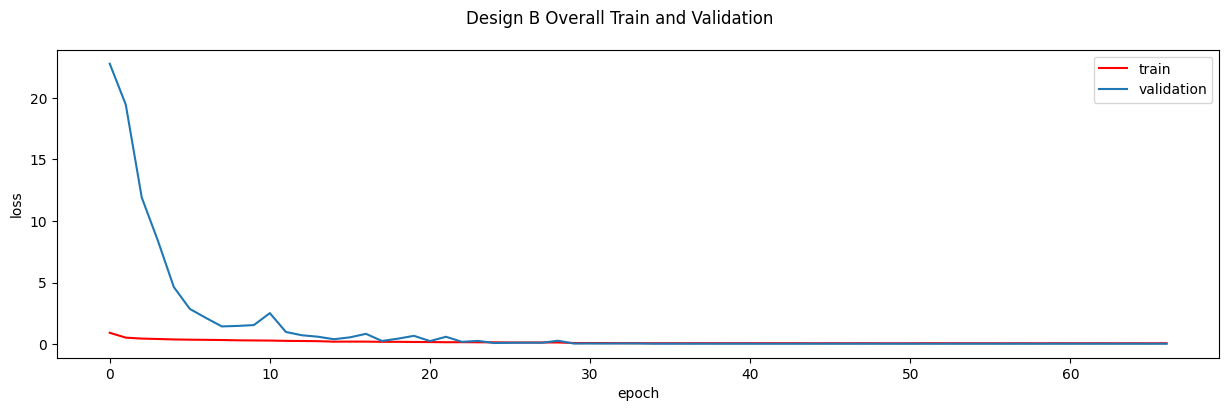

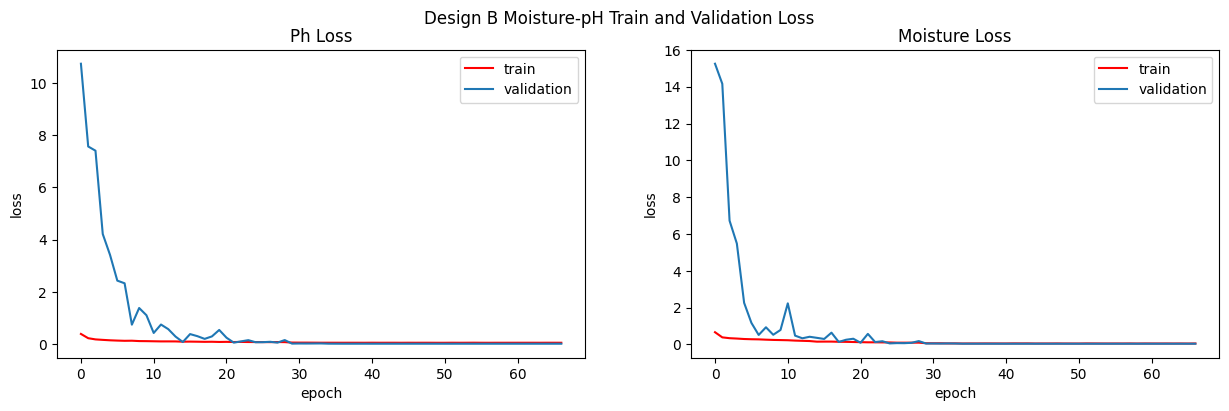

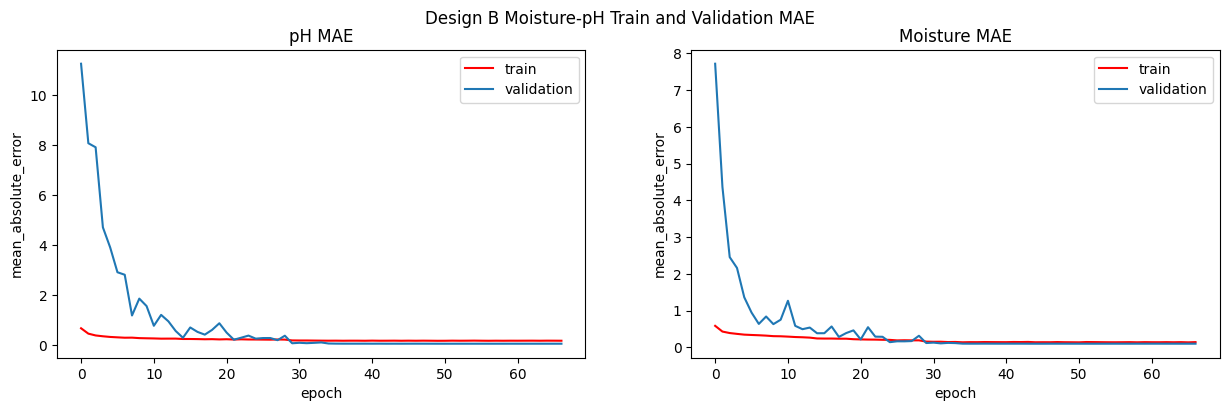

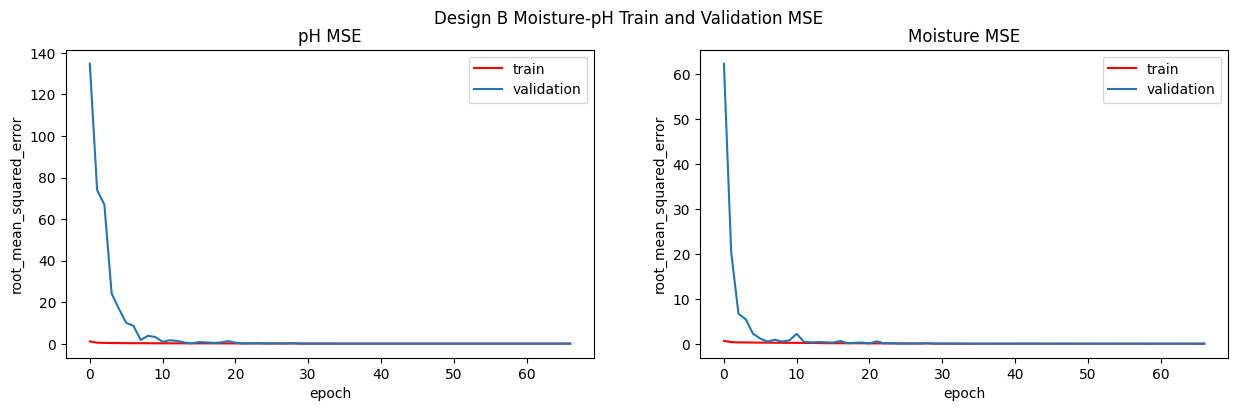

In [40]:
## Graphing Result of training
HISTORY = historyB


plt.figure(figsize=(15,4))
plt.suptitle("Design B Overall Train and Validation")

plt.subplot(111)
plt.plot(HISTORY.history['loss'], color ='r')
plt.plot(HISTORY.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation Loss")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_loss'], color ='r')
plt.plot(HISTORY.history['val_ph_output_loss'])
plt.title('Ph Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_loss'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_loss'])
plt.title('Moisture Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation MAE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_absolute_error'])
plt.title('pH MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_absolute_error'])
plt.title('Moisture MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation MSE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_squared_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_squared_error'])
plt.title('pH MSE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('root_mean_squared_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_squared_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_squared_error'])
plt.title('Moisture MSE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('root_mean_squared_error')

# displaying the figure
plt.show()

In [41]:
## Design B
history = historyB.history

loss_keys = [key for key in history.keys() if 'loss' in key]
metric_keys = [key for key in history.keys() if 'error' in key]

val_loss = history['val_loss']
best_epoch = np.argmin(val_loss)

print("Best Epoch: ", best_epoch)

for key in loss_keys + metric_keys:
    if key.startswith('val_'):
        metric_name = key[4:] 
        final_value = history[key][best_epoch]
        print(f"Final Validation {metric_name}: {final_value:.4f}")
    else:
        final_value = history[key][best_epoch]
        print(f"Final Train {key}: {final_value:.4f}")


Best Epoch:  56
Final Train loss: 0.0797
Final Train moisture_output_loss: 0.0482
Final Train ph_output_loss: 0.0450
Final Validation loss: 0.0420
Final Validation moisture_output_loss: 0.0361
Final Validation ph_output_loss: 0.0084
Final Train moisture_output_mean_absolute_error: 0.1379
Final Train moisture_output_mean_squared_error: 0.0482
Final Train ph_output_mean_absolute_error: 0.1856
Final Train ph_output_mean_squared_error: 0.0915
Final Validation moisture_output_mean_absolute_error: 0.0972
Final Validation moisture_output_mean_squared_error: 0.0361
Final Validation ph_output_mean_absolute_error: 0.0681
Final Validation ph_output_mean_squared_error: 0.0169


In [ ]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [ ]:
# modelB.save('design_models_v2/designB_v6.h5')


### Design C

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def DeeplabV3Plus(hp, input_shape=(64, 64, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50.trainable = False
    
    layer_names = [
        'conv1_relu', 'conv2_block3_out', 'conv3_block4_out',
        'conv4_block6_out', 'conv5_block3_out'
    ]
    layers_output = [resnet50.get_layer(name).output for name in layer_names]

    encoder = Model(inputs=resnet50.input, outputs=layers_output)

    # Feature extraction
    stage1, stage2, stage3, stage4, stage5 = encoder(inputs)
    
    # ASPP
    def aspp_block(x, out_channels, kernel_size, dilation):
        return layers.Conv2D(out_channels, kernel_size, padding='same', dilation_rate=dilation, activation='relu')(x)

    pool = layers.GlobalAveragePooling2D()(stage5)
    pool = layers.Reshape((1, 1, tf.keras.backend.int_shape(stage5)[-1]))(pool)
    pool = layers.Conv2D(128, (1, 1), activation='relu')(pool)
    
    shape_before = tf.keras.backend.int_shape(stage5)
    pool = layers.UpSampling2D(size=(shape_before[1], shape_before[2]))(pool)

    b1 = aspp_block(stage5, 128, 1, 1)
    b2 = aspp_block(stage5, 128, 3, 6)
    b3 = aspp_block(stage5, 128, 3, 12)
    b4 = aspp_block(stage5, 128, 3, 18)
    
    aspp_output = layers.Concatenate()([b1, b2, b3, b4, pool])
    aspp_output = layers.Conv2D(256, (1, 1), activation='relu')(aspp_output)
    
    UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)
    BATCHNORM = hp.Boolean('batchnorm', default=False)
    
    # Dense layers between encoder and decoder
    x = layers.Flatten()(aspp_output)
    x = layers.Dense(UNITS, activation='relu')(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(UNITS, activation='relu')(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(UNITS, activation='relu')(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(UNITS, activation='relu')(x)
    if BATCHNORM:
        x = layers.BatchNormalization()(x)
    
    SIZE = input_shape[0] // 32  # Adjusted to match the ASPP size
    x = layers.Dense(SIZE * SIZE * 128, activation='relu')(x)
    x = layers.Reshape((SIZE, SIZE, 128))(x)

    # Decoder pathways
    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x
    
    # Moisture pathway
    x_moisture = decoder_block(x, stage4, 256)
    x_moisture = decoder_block(x_moisture, stage3, 128)
    x_moisture = decoder_block(x_moisture, stage2, 64)
    x_moisture = decoder_block(x_moisture, stage1, 32)
    
    # x_moisture = layers.Conv2DTranspose(32, (5, 5), 2, activation='relu',padding="same",)(x_moisture)
    x_moisture = tf.keras.layers.Dropout(0.5)(x_moisture)
    moisture_output = layers.Conv2DTranspose(1, (3, 3),2, activation='relu', padding="same", name='moisture_output')(x_moisture)
    
    # pH pathway
    x_ph = decoder_block(x, stage4, 256)
    x_ph = decoder_block(x_ph, stage3, 128)
    x_ph = decoder_block(x_ph, stage2, 64)
    x_ph = decoder_block(x_ph, stage1, 32)
    
    # x_ph = layers.Conv2DTranspose(32, (5, 5), activation='relu', padding="same",)(x_ph)
    x_ph = tf.keras.layers.Dropout(0.5)(x_ph)
    ph_output = layers.Conv2DTranspose(1, (3, 3),2, activation='relu', padding="same", name='ph_output')(x_ph)
    
    model = tf.keras.Model(inputs=inputs, outputs=[moisture_output, ph_output], name='DeepLabV3Plus')

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, 
                  loss={"moisture_output": huber_moisture, "ph_output": huber_ph}, 
                  metrics={"moisture_output": [mean_squared_error, mean_absolute_error], "ph_output": [mean_squared_error, mean_absolute_error]},
                  loss_weights={'moisture_output': 1.0, 'ph_output': 0.7})
    
    return model


In [ ]:
# def convolution_block(
#     block_input,
#     num_filters=256,
#     kernel_size=3,
#     dilation_rate=1,
#     use_bias=False,
# ):
#     x = layers.Conv2D(
#         num_filters,
#         kernel_size=kernel_size,
#         dilation_rate=dilation_rate,
#         padding="same",
#         use_bias=use_bias,
#         kernel_initializer=keras.initializers.HeNormal(),
#     )(block_input)
#     x = layers.BatchNormalization()(x)
#     return tf.keras.layers.ReLU()(x)


# def DilatedSpatialPyramidPooling(dspp_input):
#     dims = dspp_input.shape
#     x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
#     x = convolution_block(x, kernel_size=1, use_bias=True)
#     out_pool = layers.UpSampling2D(
#         size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
#         interpolation="bilinear",
#     )(x)

#     out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
#     out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
#     out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
#     out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

#     x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
#     output = convolution_block(x, kernel_size=1)
#     return output

# def DeeplabV3Plus(hp, image_size=64):
#     model_input = keras.Input(shape=(image_size, image_size, 3))
#     preprocessed = keras.applications.resnet50.preprocess_input(model_input)
#     resnet50 = keras.applications.ResNet50(
#         weights="imagenet", include_top=False, input_tensor=preprocessed
#     )
#     x = resnet50.get_layer("conv4_block6_2_relu").output
#     x = DilatedSpatialPyramidPooling(x)
    
#     UNITS = hp.Choice('units', values=[256, 512, 1024, 2048], default=256)
#     DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1, default=0.0)
#     BATCHNORM = hp.Boolean('batchnorm', default=False)
    
#     # Dense layers between encoder and decoder
#     x = layers.Flatten()(x)
#     x = layers.Dense(UNITS, activation='relu')(x)
#     x = layers.Dropout(DROPOUT)(x)
#     x = layers.Dense(UNITS, activation='relu')(x)
#     x = layers.Dropout(DROPOUT)(x)
#     x = layers.Dense(UNITS, activation='relu')(x)
#     x = layers.Dropout(DROPOUT)(x)
#     x = layers.Dense(UNITS, activation='relu')(x)
#     if BATCHNORM:
#         x = layers.BatchNormalization()(x)
    
#     SIZE = image_size // 32  # Adjusted to match the ASPP size
#     x = layers.Dense(SIZE * SIZE * 256, activation='relu')(x)
#     x = layers.Reshape((SIZE, SIZE, 256))(x)

#     input_a_moisture = layers.UpSampling2D(
#         size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
#         interpolation="bilinear",
#     )(x)
#     input_b_moisture = resnet50.get_layer("conv2_block3_2_relu").output
#     input_b_moisture = convolution_block(input_b_moisture, num_filters=48, kernel_size=1)

#     x_moisture = layers.Concatenate(axis=-1)([input_a_moisture, input_b_moisture])
#     x_moisture = convolution_block(x_moisture, num_filters=128)
#     x_moisture = convolution_block(x_moisture, num_filters=128)
#     x_moisture = layers.UpSampling2D(
#         size=(image_size // x_moisture.shape[1], image_size // x_moisture.shape[2]),
#         interpolation="bilinear",
#     )(x_moisture)
#     moisture_output = layers.Conv2D(1, kernel_size=(1, 1), padding="same", name="moisture_output")(x_moisture)
    
#     input_a_ph = layers.UpSampling2D(
#         size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
#         interpolation="bilinear",
#     )(x)
#     input_b_ph = resnet50.get_layer("conv2_block3_2_relu").output
#     input_b_ph = convolution_block(input_b_ph, num_filters=48, kernel_size=1)
#     x_ph = layers.Concatenate(axis=-1)([input_a_ph, input_b_ph])
#     x_ph = convolution_block(x_ph, num_filters=128)
#     x_ph = convolution_block(x_ph, num_filters=128)
#     x_ph = layers.UpSampling2D(
#         size=(image_size // x_ph.shape[1], image_size // x_ph.shape[2]),
#         interpolation="bilinear",
#     )(x_ph)
#     ph_output = layers.Conv2D(1, kernel_size=(1, 1), padding="same", name="ph_output")(x_ph)
    
#     model = tf.keras.Model(inputs=model_input, outputs=[moisture_output, ph_output], name='DeepLabV3Plus')

#     optimizer_choice = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'], default='adam')
#     lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)

#     if optimizer_choice == 'sgd':
#         optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
#     elif optimizer_choice == 'rmsprop':
#         optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
#     else:
#         optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#     model.compile(optimizer=optimizer, 
#                   loss={"moisture_output": huber_moisture, "ph_output": huber_ph}, 
#                   metrics={"moisture_output": [mean_squared_error, mean_absolute_error], "ph_output": [mean_squared_error, mean_absolute_error]},
#                   loss_weights={'moisture_output': 1.0, 'ph_output': 0.7})
    
    
#     return model

In [ ]:
tunerC = kt.BayesianOptimization(DeeplabV3Plus,
                     objective='val_loss',
                     directory='my_dir_v2-06-12-2024',
                     max_trials= 30,
                     project_name='design_c',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)

tunerC.search(train_generator, epochs=30, validation_data=val_generator, callbacks=[stop_early, reduce_lr])

# Get the optimal hyperparameters
best_hpsC=tunerC.get_best_hyperparameters(num_trials=1)[0]

print(best_hpsC.values)

Reloading Tuner from my_dir_v2-06-12-2024\design_c\tuner0.json
{'units': 256, 'dropout': 0.1, 'batchnorm': True, 'optimizer': 'adam', 'learning_rate': 0.001}


In [ ]:
modelC = DeeplabV3Plus(best_hpsC)
modelC.summary()



Model: "DeepLabV3Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_138 (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_62 (Functional)          [(None, 32, 32, 64)  23587712    ['input_138[0][0]']              
                                , (None, 16, 16, 25                                               
                                6),                                                               
                                 (None, 8, 8, 512),                                               
                                 (None, 4, 4, 1024)                                               
                                , (None, 2, 2, 2048                                   

In [ ]:
import time 
training_arrayC = []
for i in range(10):
    modelC = DeeplabV3Plus(best_hpsC)
    start = time.time()
    historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=0, callbacks = [ES, REDUCE_LR])
    stop = time.time()
    training_arrayC.append(stop - start)
    print(f"Training time: {stop - start}s")
print("Final Training Time: {}".format(sum(training_arrayC)/len(training_arrayC)))

Training time: 207.9274709224701s
Training time: 190.80209183692932s
Training time: 165.0049376487732s
Training time: 177.74280047416687s
Training time: 218.15357446670532s
Training time: 171.63583636283875s
Training time: 262.40045285224915s
Training time: 239.5936005115509s
Training time: 278.0445137023926s
Training time: 197.7475574016571s
Final Training Time: 210.90528361797334


In [ ]:
## DESIGN C
import time 
modelC = DeeplabV3Plus(best_hpsC)
start = time.time()
historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [ES, REDUCE_LR])
stop = time.time()
print(f"Training time: {stop - start}s")

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1048576,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
# truths = []
# preds = []
# for i in range(TRAIN_RANGE):
#     predictions = modelC.predict(np.array([SAMPLE_TRAIN[i]]))
#     truths.append(unprocess_label_wmask(SAMPLE_TRAIN[i],SAMPLE_TRAIN_Y[i]))
#     preds.append(unprocess_label_wmask(SAMPLE_TRAIN[i],predictions))
# truths_moisture = [round(truth[0],2) for truth in truths]
# truths_ph = [round(truth[1],2) for truth in truths]
# preds_moisture = [round(pred[0],2) for pred in preds]
# preds_ph = [round(pred[1],2) for pred in preds]


# for i in range(len(truths_moisture)):
#     print(i, end=" ")
#     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
#     print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# plt.figure(figsize=(12, 6))

# # Moisture Plot
# plt.subplot(2, 1, 1)
# plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
# plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
# plt.title('Moisture Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('Moisture')
# plt.legend()

# # pH Plot
# plt.subplot(2, 1, 2)
# plt.plot(truths_ph, label='Truths - pH', marker='o')
# plt.plot(preds_ph, label='Preds - pH', marker='x')
# plt.title('pH Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('pH')
# plt.legend()

# plt.tight_layout()
# plt.show()

# def accuracy(truth, pred):
#     return (1 - abs(truth - pred) / truth) * 100

# TEMP_0 = []
# TEMP_1 = []
# for i in range(len(truths_moisture)):
#     TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
#     TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
# print(np.mean(np.array(TEMP_0)))
# print(np.mean(np.array(TEMP_1)))


In [ ]:

# truths = []
# preds = []
# for i in range(20):
#     predictions = modelC.predict(np.array([SAMPLE[i]]))
#     truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
#     preds.append(unprocess_label_wmask(SAMPLE[i],predictions))
# truths_moisture = [truth[0] for truth in truths]
# truths_ph = [truth[1] for truth in truths]
# preds_moisture = [pred[0] for pred in preds]
# preds_ph = [pred[1] for pred in preds]

# for i in range(len(truths_moisture)):
#     print(i, end=" ")
#     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
#     print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
# plt.figure(figsize=(12, 6))

# # Moisture Plot
# plt.subplot(2, 1, 1)
# plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
# plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
# plt.title('Moisture Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('Moisture')
# plt.legend()

# # pH Plot
# plt.subplot(2, 1, 2)
# plt.plot(truths_ph, label='Truths - pH', marker='o')
# plt.plot(preds_ph, label='Preds - pH', marker='x')
# plt.title('pH Comparison')
# plt.xlabel('Sample Index')
# plt.ylabel('pH')
# plt.legend()

# plt.tight_layout()
# plt.show()

# def accuracy(truth, pred):
#     return (1 - abs(truth - pred) / truth) * 100

# TEMP_0 = []
# TEMP_1 = []
# for i in range(len(truths_moisture)):
#     TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
#     TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
# print(np.mean(np.array(TEMP_0)))
# print(np.mean(np.array(TEMP_1)))



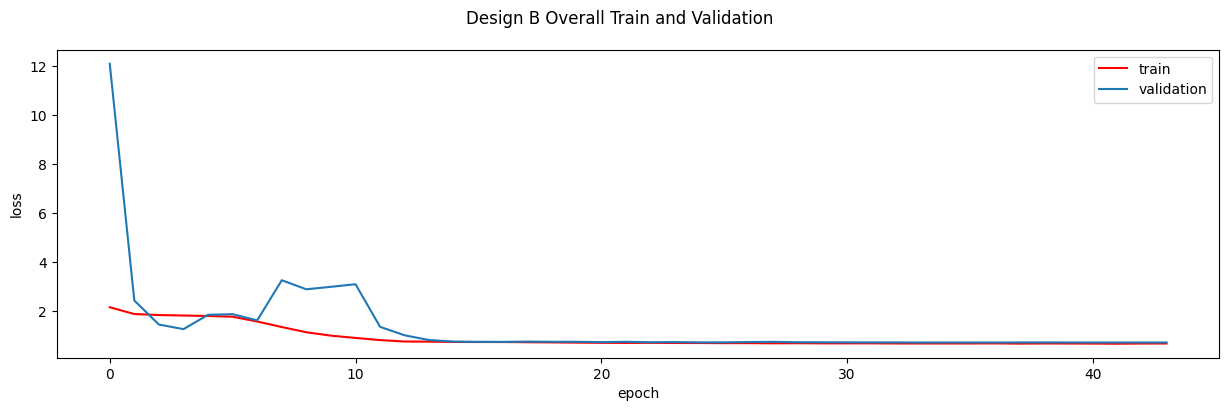

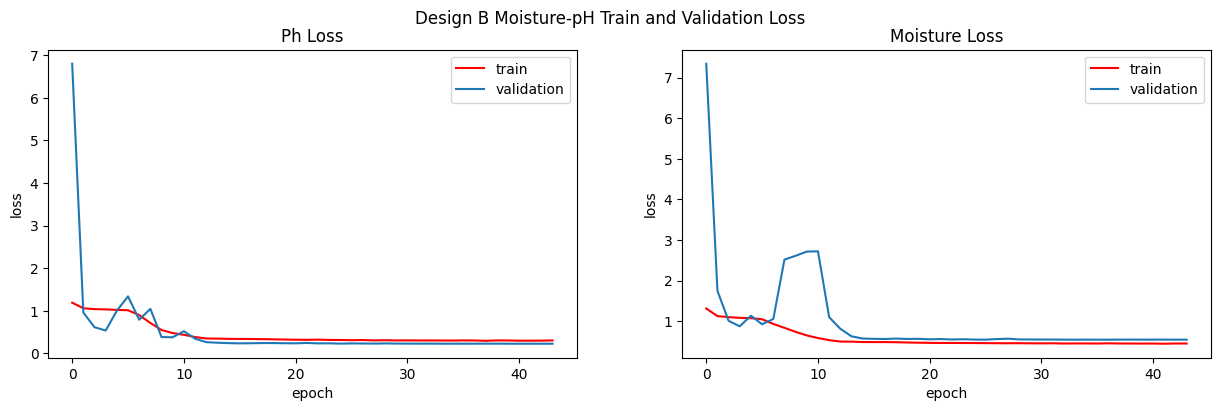

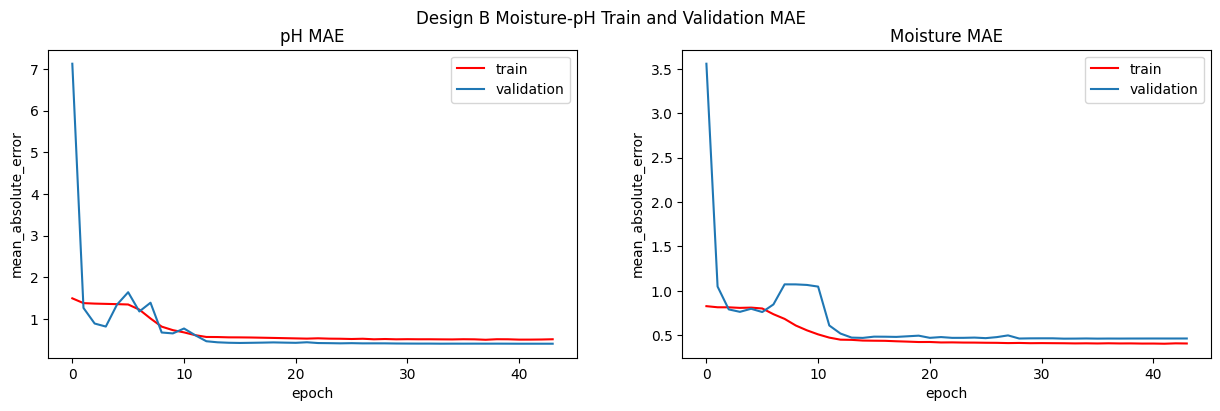

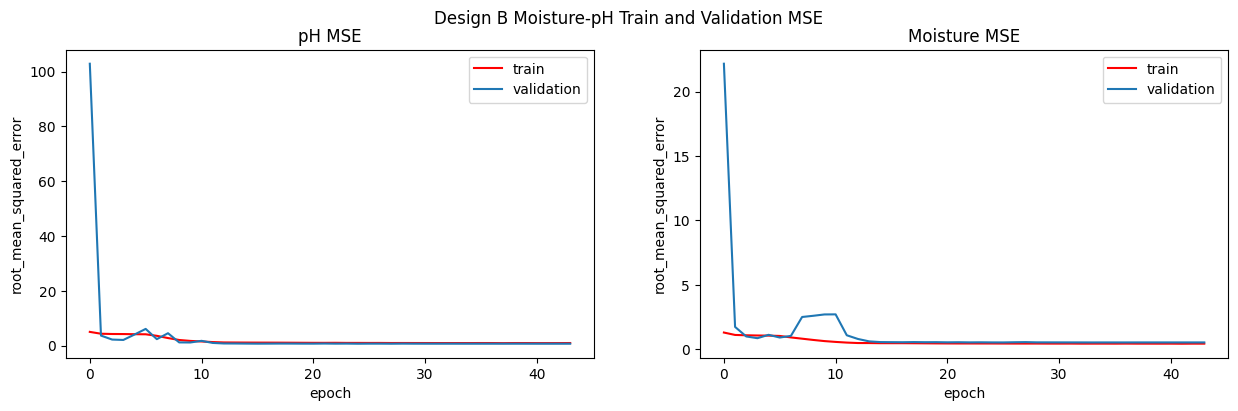

In [ ]:
## Graphing Result of training
HISTORY = historyC


plt.figure(figsize=(15,4))
plt.suptitle("Design B Overall Train and Validation")

plt.subplot(111)
plt.plot(HISTORY.history['loss'], color ='r')
plt.plot(HISTORY.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation Loss")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_loss'], color ='r')
plt.plot(HISTORY.history['val_ph_output_loss'])
plt.title('Ph Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_loss'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_loss'])
plt.title('Moisture Loss')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation MAE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_absolute_error'])
plt.title('pH MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_absolute_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_absolute_error'])
plt.title('Moisture MAE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')

# displaying the figure
plt.show()

plt.figure(figsize=(15,4))
plt.suptitle("Design B Moisture-pH Train and Validation MSE")

plt.subplot(121)
plt.plot(HISTORY.history['ph_output_mean_squared_error'], color ='r')
plt.plot(HISTORY.history['val_ph_output_mean_squared_error'])
plt.title('pH MSE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('root_mean_squared_error')

plt.subplot(122)
plt.plot(HISTORY.history['moisture_output_mean_squared_error'], color ='r')
plt.plot(HISTORY.history['val_moisture_output_mean_squared_error'])
plt.title('Moisture MSE')
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('root_mean_squared_error')

# displaying the figure
plt.show()

In [ ]:
## Design B
history = historyC.history

loss_keys = [key for key in history.keys() if 'loss' in key]
metric_keys = [key for key in history.keys() if 'error' in key]

val_loss = history['val_loss']
best_epoch = np.argmin(val_loss)

print("Best Epoch: ", best_epoch)

for key in loss_keys + metric_keys:
    if key.startswith('val_'):
        metric_name = key[4:] 
        final_value = history[key][best_epoch]
        print(f"Final Validation {metric_name}: {final_value:.4f}")
    else:
        final_value = history[key][best_epoch]
        print(f"Final Train {key}: {final_value:.4f}")


Best Epoch:  33
Final Train loss: 0.6612
Final Train moisture_output_loss: 0.4491
Final Train ph_output_loss: 0.3031
Final Validation loss: 0.7010
Final Validation moisture_output_loss: 0.5415
Final Validation ph_output_loss: 0.2279
Final Train moisture_output_mean_squared_error: 0.4491
Final Train moisture_output_mean_absolute_error: 0.4071
Final Train ph_output_mean_squared_error: 0.9299
Final Train ph_output_mean_absolute_error: 0.5075
Final Validation moisture_output_mean_squared_error: 0.5415
Final Validation moisture_output_mean_absolute_error: 0.4613
Final Validation ph_output_mean_squared_error: 0.6922
Final Validation ph_output_mean_absolute_error: 0.4035


In [ ]:
# from shutil import rmtree
# # removing directory 
# rmtree('my_dir') 

In [ ]:
# modelC.save('design_models_v2/designC_v6.h5')


## Evaluating Constraints

### MANUFACTURABILITY: TRAINING TIME

In [32]:
# modelA = tf.keras.models.load_model('design_models_v2/designA_v12.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})
modelB = tf.keras.models.load_model('design_models_v2/designB_v16/designB_v0.h5',         custom_objects = {
            'root_mean_squared_error': root_mean_squared_error,
            'mean_absolute_error': mean_absolute_error,
            'huber_ph': huber_ph,
            'huber_moisture': huber_moisture
            })
# modelC = tf.keras.models.load_model('design_models_v2/designC_v12.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})


In [ ]:
# epochs = 128
# REDUCE_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=5, min_lr=1e-9)
# ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, mode="min", restore_best_weights=True)

In [ ]:
# ## DESIGN A
# import time 
# start = time.time()
# historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

# # ## FUNCTIONALITY: INFERENCE TIME
# # modelC.evaluate(train_generator[1][0][0].reshape(1,32,32,3))

In [ ]:
# ## DESIGN B
# import time 
# start = time.time()
# historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

In [ ]:
# ## DESIGN C
# import time 
# start = time.time()
# historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [es, reduce_lr])
# stop = time.time()
# print(f"Training time: {stop - start}s")

### ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND

In [ ]:
## Design A
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsA = get_flops(modelA, batch_size=1)
print(f"FLOPS: {flopsA}")

FLOPS: 4184112296


In [ ]:
## Design B
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsB = get_flops(modelB, batch_size=1)
print(f"FLOPS: {flopsB}")

FLOPS: 3830278292


In [ ]:
## Design C
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculate FLOPS
from keras_flops import get_flops
flopsC = get_flops(modelC, batch_size=1)
print(f"FLOPS: {flopsC}")

FLOPS: 8044830098


### FUNCTIONALITY: INFERENCE TIME

In [ ]:
# inference_sample = train_generator[1][0][0].reshape(1,64,64,3)

In [35]:
inference_sample = []
for i in range(3):
    for j in range(4):
        inference_sample.append(train_generator[i][0][j].reshape(1,64,64,3)) 
        if len(inference_sample) == 10: break
    if len(inference_sample) == 10: break
print(len(inference_sample))

10


In [50]:
import time
## Design A
## FUNCTIONALITY: INFERENCE TIME
ARR = []
for i in range(10):
    start = time.time()
    modelA.predict(inference_sample[i], verbose=0)
    stop = time.time()
    ARR.append(stop - start)
    print(f"Inference time: {(stop - start)*1e3:.4f}ms")
print("Final Inference Time: {:.4f}".format((sum(ARR)/len(ARR))*1e3))

Inference time: 77.9228ms
Inference time: 80.1854ms
Inference time: 80.0045ms
Inference time: 76.9804ms
Inference time: 89.1988ms
Inference time: 78.8276ms
Inference time: 82.1686ms
Inference time: 75.8083ms
Inference time: 77.6796ms
Inference time: 77.7090ms
Final Inference Time: 79.6485


In [ ]:
## Design B
## FUNCTIONALITY: INFERENCE TIME
ARR = []
for i in range(10):
    start = time.time()
    time.sleep(0.03)
    modelB.predict(inference_sample[i], verbose=0)
    stop = time.time()
    ARR.append(stop - start)
    print(f"Inference time: {(stop - start)*1e3:.4f}ms")
print("Final Inference Time: {:.4f}".format((sum(ARR)/len(ARR))*1e3))

Inference time: 254.7238ms
Inference time: 98.0496ms
Inference time: 91.9862ms
Inference time: 93.7722ms
Inference time: 94.1086ms
Inference time: 96.4272ms
Inference time: 87.8084ms
Inference time: 93.4362ms
Inference time: 94.6195ms
Inference time: 94.6023ms
Final Inference Time: 109.9534


In [ ]:
## Design C
## FUNCTIONALITY: INFERENCE TIME
ARR = []
for i in range(10):
    start = time.time()
    modelC.predict(inference_sample[i], verbose=0)
    stop = time.time()
    ARR.append(stop - start)
    print(f"Inference time: {(stop - start)*1e3:.4f}ms")
print("Final Inference Time: {:.4f}".format((sum(ARR)/len(ARR))*1e3))

Inference time: 233.9723ms
Inference time: 61.8145ms
Inference time: 63.8480ms
Inference time: 63.6504ms
Inference time: 63.7522ms
Inference time: 61.5585ms
Inference time: 61.9202ms
Inference time: 61.2829ms
Inference time: 67.1115ms
Inference time: 61.9259ms
Final Inference Time: 80.0836


### PERFORMANCE: COEFFICIENT OF DETERMINATION

In [ ]:
## Design A
## PERFORMANCE: COEFFICIENT OF DETERMINATION
import numpy as np
from sklearn.metrics import r2_score

y_values_1 = np.array(y_values_1)
predictionsA = modelA.predict(gen_X_values_1_1)

y_values_flat_0 = y_values_1[: ,0].flatten()
predictionsA_flat_0 = predictionsA[0].flatten()

y_values_flat_1 = y_values_1[: ,1].flatten()
predictionsA_flat_1 = predictionsA[1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsA_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsA_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")



79/79 [==============================] - 10s 49ms/step
R^2 for class 0: 0.7606
R^2 for class 1: 0.8877
Average R^2 score: 0.8242


In [ ]:
## Design B
## PERFORMANCE: COEFFICIENT OF DETERMINATION

y_values_1 = np.array(y_values_1)
predictionsA = modelB.predict(gen_X_values_2_1)

y_values_flat_0 = y_values_1[: ,0].flatten()
predictionsA_flat_0 = predictionsA[0].flatten()

y_values_flat_1 = y_values_1[: ,1].flatten()
predictionsA_flat_1 = predictionsA[1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsA_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsA_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")



79/79 [==============================] - 2s 23ms/step
R^2 for class 0: 0.9488
R^2 for class 1: 0.9566
Average R^2 score: 0.9527


In [ ]:
## Design C
## PERFORMANCE: COEFFICIENT OF DETERMINATION
y_values_1 = np.array(y_values_1)
predictionsA = modelC.predict(gen_X_values_3_1)

y_values_flat_0 = y_values_1[: ,0].flatten()
predictionsA_flat_0 = predictionsA[0].flatten()

y_values_flat_1 = y_values_1[: ,1].flatten()
predictionsA_flat_1 = predictionsA[1].flatten()

# Calculate R^2 score for each class
r2_score_0 = r2_score(y_values_flat_0, predictionsA_flat_0)
r2_score_1 = r2_score(y_values_flat_1, predictionsA_flat_1)

print(f'R^2 for class 0: {r2_score_0:.4f}')
print(f'R^2 for class 1: {r2_score_1:.4f}')

print(f"Average R^2 score: {(r2_score_0+r2_score_1)/2:.4f}")




79/79 [==============================] - 8s 35ms/step
R^2 for class 0: -0.5979
R^2 for class 1: -0.6993
Average R^2 score: -0.6486


### EFFICIENCY: STORAGE CONSUMPTION

In [ ]:
## Design A
## EFFICIENCY: STORAGE CONSUMPTION
weightsA = modelA.get_weights()
total_sizeA = 0
for weight in weightsA:
    total_sizeA += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeA*8e-6:.4f}")

Total model weight size in megabytes: 647.8597


In [ ]:
## Design B
## EFFICIENCY: STORAGE CONSUMPTION
weightsB = modelB.get_weights()
total_sizeB = 0
for weight in weightsB:
    total_sizeB += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeB*8e-6:.4f}")

Total model weight size in megabytes: 276.6177


In [ ]:
## Design C
## EFFICIENCY: STORAGE CONSUMPTION
weightsC = modelC.get_weights()
total_sizeC = 0
for weight in weightsC:
    total_sizeC += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeC*8e-6:.4f}")

Total model weight size in megabytes: 512.3871


In [ ]:
# modelB.save('design_models_v2/designB_v10.h5')


## Saving final trained and constrained models

In [41]:
import os
import matplotlib.pyplot as plt
def save_model_and_metrics(model, path, HISTORY):
    import numpy as np
    

    def accuracy(truth, pred):
        return (1 - abs(truth - pred) / truth) * 100
    
    os.mkdir(path)
    model.save(path+'designB_v0.h5')
    truths = []
    preds = []
    for i in range(TRAIN_RANGE):
        predictions = model.predict(np.array([SAMPLE_TRAIN[i]]))
        truths.append(unprocess_label_wmask(SAMPLE_TRAIN[i],SAMPLE_TRAIN_Y[i]))
        preds.append(unprocess_label_wmask(SAMPLE_TRAIN[i],predictions))
    truths_moisture = [truth[0] for truth in truths]
    truths_ph = [truth[1] for truth in truths]
    preds_moisture = [pred[0] for pred in preds]
    preds_ph = [pred[1] for pred in preds]
    
    TEMP_0_TRAIN = []
    TEMP_1_TRAIN = []
    for i in range(len(truths_moisture)):
        TEMP_0_TRAIN.append(accuracy(truths_moisture[i],preds_moisture[i]))
        TEMP_1_TRAIN.append(accuracy(truths_ph[i],preds_ph[i]))


    # for i in range(len(truths_moisture)):
    #     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    #     print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
    plt.figure(figsize=(12, 6))

    # Moisture Plot
    plt.subplot(2, 1, 1)
    plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
    plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
    plt.title('Moisture Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Moisture')
    plt.legend()

    # pH Plot
    plt.subplot(2, 1, 2)
    plt.plot(truths_ph, label='Truths - pH', marker='o')
    plt.plot(preds_ph, label='Preds - pH', marker='x')
    plt.title('pH Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('pH')
    plt.legend()

    plt.tight_layout()
    plt.savefig(path+"train_set.jpg")

    ## TEST
    truths = []
    preds = []
    for i in range(20):
        predictions = model.predict(np.array([SAMPLE[i]]))
        truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
        preds.append(unprocess_label_wmask(SAMPLE[i],predictions))
    truths_moisture = [truth[0] for truth in truths]
    truths_ph = [truth[1] for truth in truths]
    preds_moisture = [pred[0] for pred in preds]
    preds_ph = [pred[1] for pred in preds]

    TEMP_0_TEST = []
    TEMP_1_TEST = []
    for i in range(len(truths_moisture)):
        TEMP_0_TEST.append(accuracy(truths_moisture[i],preds_moisture[i]))
        TEMP_1_TEST.append(accuracy(truths_ph[i],preds_ph[i]))

    # for i in range(len(truths_moisture)):
    #     print("Moisture Truth : {:.2f} Pred: {:.2f}".format(truths_moisture[i], preds_moisture[i]))
    #     print("ph   Truth: {:.2f} Pred: {:.2f}".format(truths_ph[i], preds_ph[i]), end="\n\n")
    plt.figure(figsize=(12, 6))

    # Moisture Plot
    plt.subplot(2, 1, 1)
    plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
    plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
    plt.title('Moisture Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Moisture')
    plt.legend()

    # pH Plot
    plt.subplot(2, 1, 2)
    plt.plot(truths_ph, label='Truths - pH', marker='o')
    plt.plot(preds_ph, label='Preds - pH', marker='x')
    plt.title('pH Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('pH')
    plt.legend()

    plt.tight_layout()
    plt.savefig(path+"test_set.jpg")

    ## Graphing Result of training

    plt.figure(figsize=(15,4))
    plt.suptitle("Design B Overall Train and Validation")

    plt.subplot(111)
    plt.plot(HISTORY.history['loss'], color ='r')
    plt.plot(HISTORY.history['val_loss'])
    plt.legend(['train','validation'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(path+"Design B Overall Train and Validation.jpg")



    plt.figure(figsize=(15,4))
    plt.suptitle("Design B Moisture-pH Train and Validation Loss")

    plt.subplot(121)
    plt.plot(HISTORY.history['ph_output_loss'], color ='r')
    plt.plot(HISTORY.history['val_ph_output_loss'])
    plt.title('Ph Loss')
    plt.legend(['train','validation'])
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(122)
    plt.plot(HISTORY.history['moisture_output_loss'], color ='r')
    plt.plot(HISTORY.history['val_moisture_output_loss'])
    plt.title('Moisture Loss')
    plt.legend(['train','validation'])
    plt.xlabel('epoch')
    plt.ylabel('loss')

    # displaying the figure
    plt.savefig(path+"Design B Moisture-pH Train and Validation Loss.jpg")


    plt.figure(figsize=(15,4))
    plt.suptitle("Design B Moisture-pH Train and Validation MAE")

    plt.subplot(121)
    plt.plot(HISTORY.history['ph_output_mean_absolute_error'], color ='r')
    plt.plot(HISTORY.history['val_ph_output_mean_absolute_error'])
    plt.title('pH MAE')
    plt.legend(['train','validation'])
    plt.xlabel('epoch')
    plt.ylabel('mean_absolute_error')

    plt.subplot(122)
    plt.plot(HISTORY.history['moisture_output_mean_absolute_error'], color ='r')
    plt.plot(HISTORY.history['val_moisture_output_mean_absolute_error'])
    plt.title('Moisture MAE')
    plt.legend(['train','validation'])
    plt.xlabel('epoch')
    plt.ylabel('mean_absolute_error')

    # displaying the figure
    plt.savefig(path+"Design B Moisture-pH Train and Validation MAE.jpg")


    plt.figure(figsize=(15,4))
    plt.suptitle("Design B Moisture-pH Train and Validation MSE")

    plt.subplot(121)
    plt.plot(HISTORY.history['ph_output_mean_squared_error'], color ='r')
    plt.plot(HISTORY.history['val_ph_output_mean_squared_error'])
    plt.title('pH MSE')
    plt.legend(['train','validation'])
    plt.xlabel('epoch')
    plt.ylabel('root_mean_squared_error')

    plt.subplot(122)
    plt.plot(HISTORY.history['moisture_output_mean_squared_error'], color ='r')
    plt.plot(HISTORY.history['val_moisture_output_mean_squared_error'])
    plt.title('Moisture MSE')
    plt.legend(['train','validation'])
    plt.xlabel('epoch')
    plt.ylabel('root_mean_squared_error')

    # displaying the figure
    plt.savefig(path+"Design B Moisture-pH Train and Validation MSE.jpg")

    loss_keys = [key for key in HISTORY.history.keys() if 'loss' in key]
    metric_keys = [key for key in HISTORY.history.keys() if 'error' in key]

    val_loss = HISTORY.history['val_loss']
    best_epoch = np.argmin(val_loss)

    # Open the file for writing in text mode with descriptive filename
    with open(path + "training_results.txt", "w") as f:
        f.write("Best Epoch: {}\n".format(best_epoch))

        for key in loss_keys + metric_keys:
            if key.startswith('val_'):
                metric_name = key[4:]
                final_value = HISTORY.history[key][best_epoch]
                f.write(f"Final Validation {metric_name}: {final_value:.4f}\n")
            else:
                metric_name = key  # Define metric_name here as well
                final_value = HISTORY.history[key][best_epoch]
                f.write(f"Final Train {metric_name}: {final_value:.4f}\n")
        f.write("Train Accuracy Moisture: {:.2f} \n".format(np.mean(np.array(TEMP_0_TRAIN))))
        f.write("Train Accuracy pH: {:.2f} \n".format(np.mean(np.array(TEMP_1_TRAIN))))
        f.write("Test Accuracy Moisture: {:.2f} \n".format(np.mean(np.array(TEMP_0_TEST))))
        f.write("Test Accuracy pH: {:.2f} \n".format(np.mean(np.array(TEMP_1_TEST))))


In [42]:
# path = 'design_models_v2/designA_v19/'
# save_model_and_metrics(modelA, path, historyA)

1/1 [==============================] - 0s 20ms/step


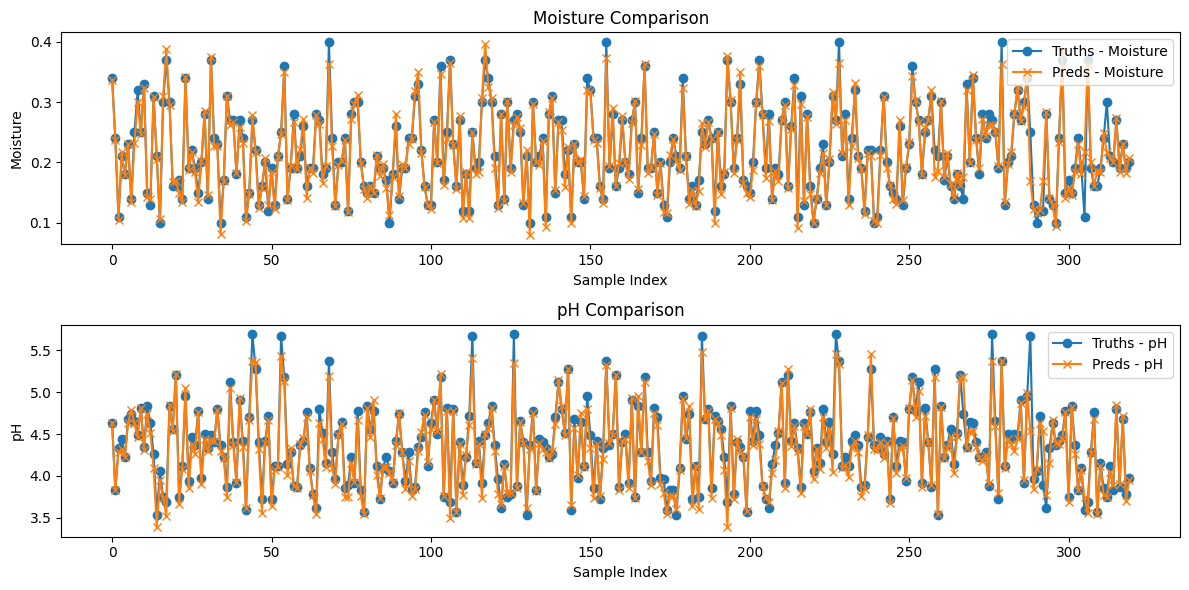

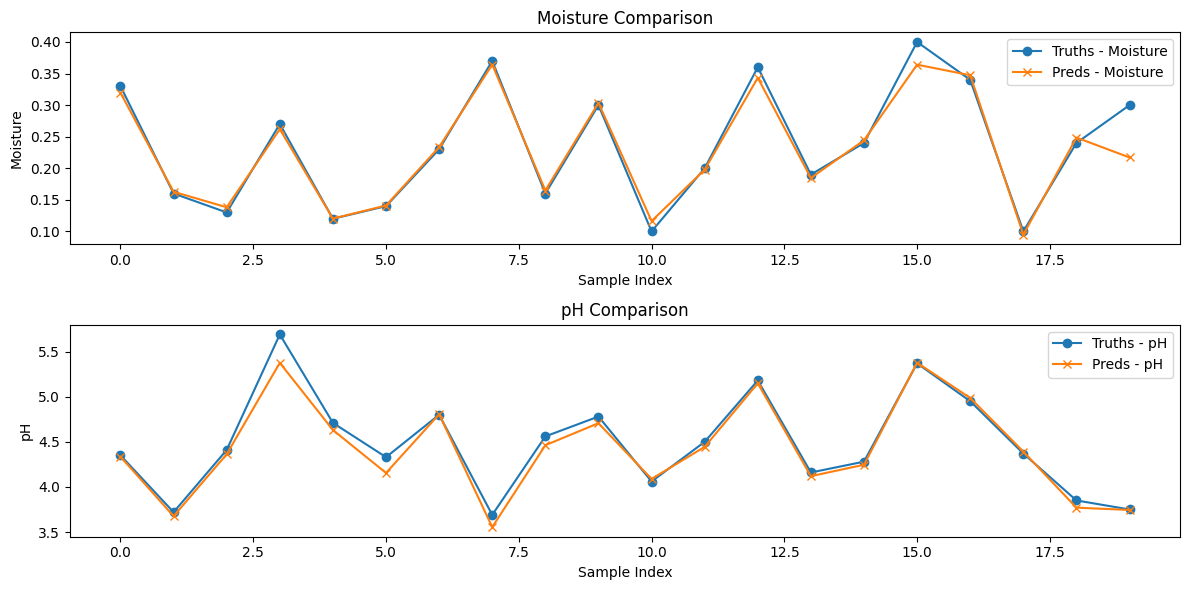

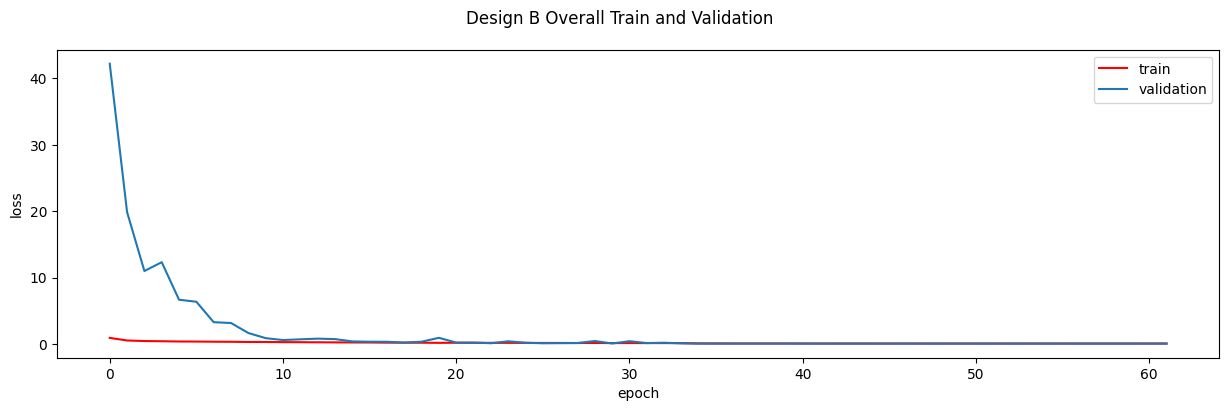

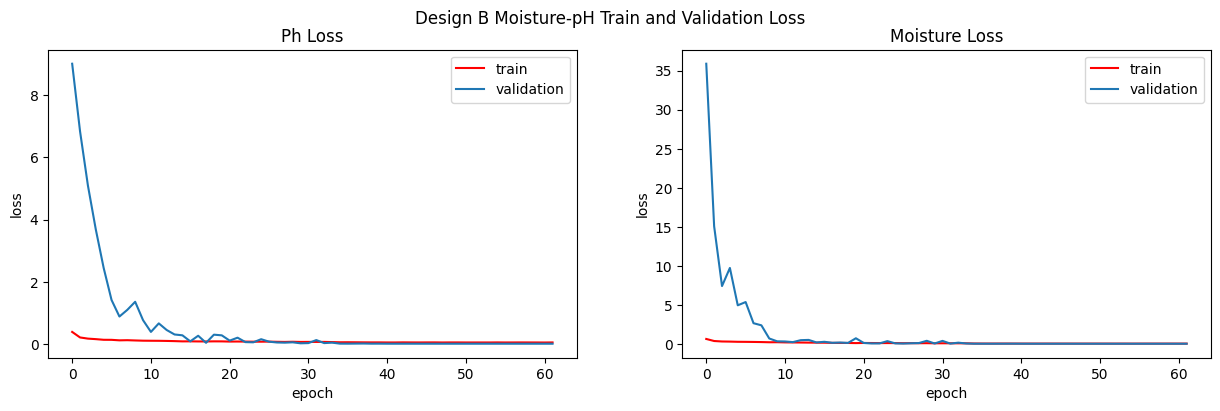

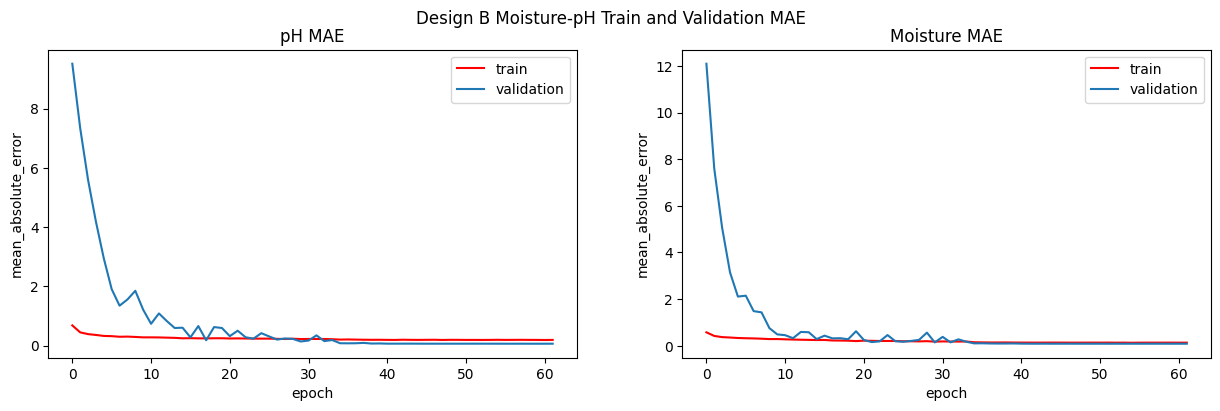

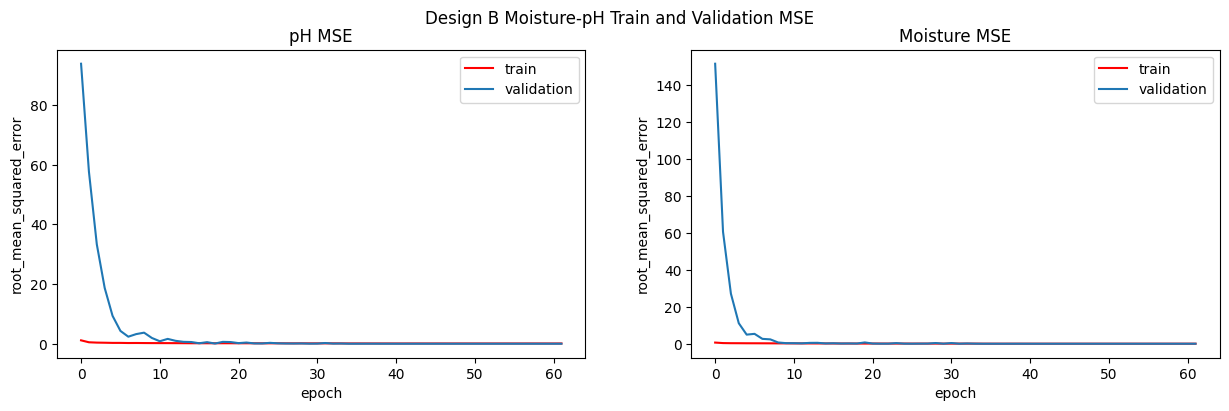

In [43]:


path = 'design_models_v2/designB_v39/'
save_model_and_metrics(modelB, path, historyB)

# 


In [ ]:
# path = 'design_models_v2/designC_v19/'
# save_model_and_metrics(modelC, path, historyC)

In [ ]:
# modelA.save('design_models_v2/designA_v12.h5')
# modelB.save('design_models_v2/designB_v0.h5')
# modelC.save('design_models_v2/designC_v12.h5')

In [ ]:
# designB_v13 is good model with multiple decoder subnetworks

# Testing Accuracy of Models

In [ ]:
## Prepare set of x values and y values for performance constraint
X_values,y_values = [],[]
for i in range(100):
    values = next(val_generator)
    # for j in range(values[0].shape[0]):
    X_values.append(values[0])
    y_values.append(values[1])

TypeError: 'MultiOutputDataGenerator' object is not an iterator